In [1]:
#standard ML/Image Processing imports
import numpy as np
import pandas as pd
import math, pandas
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#pytorch imports
import torch
import torch.optim as optim
import torchvision.models as models

from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# no one likes irrelevant warnings
import warnings  
warnings.filterwarnings('ignore')

# root directory where the images are stored
data_dir = "/mnt/md0/reynolds/ava-dataset/"
label_file = "/mnt/md0/reynolds/ava-dataset/AVA_dataset/AVA.txt"

In [2]:
pic_label_dict = {}
limit_lines = 1000000
f = open(label_file, "r")
for i, line in enumerate(f):
    if i >= limit_lines:
        break
    line_array = line.split()
#     print(line_array)
    picture_name = line_array[1]
    # print(picture_name)
    temp = line_array[2:]
    # print(temp)
    aesthetic_values = temp[:10]
    # print(aesthetic_values)
    for i in range(0, len(aesthetic_values)): 
        aesthetic_values[i] = int(aesthetic_values[i])
    # print(max(aesthetic_values))
    pic_label_dict[picture_name] = np.asarray(aesthetic_values).argmax()
print(pic_label_dict)

{'953619': 4, '953958': 3, '954184': 5, '954113': 4, '953980': 4, '954175': 5, '953349': 5, '953645': 5, '953897': 5, '953841': 5, '953417': 5, '953777': 5, '953756': 5, '954195': 4, '953903': 5, '954222': 5, '953889': 5, '953844': 5, '954104': 5, '954229': 4, '953550': 5, '953726': 4, '954228': 4, '953750': 4, '954181': 5, '954208': 5, '953810': 5, '954187': 4, '953621': 5, '953348': 4, '953283': 5, '953092': 5, '953751': 5, '954112': 4, '954117': 5, '954116': 5, '953821': 5, '954105': 5, '953019': 4, '953780': 4, '954186': 4, '954119': 5, '954063': 4, '954121': 5, '954066': 4, '954125': 4, '954067': 5, '953582': 5, '954013': 5, '954069': 4, '954071': 4, '954225': 4, '954124': 5, '954218': 5, '953577': 5, '953985': 5, '954141': 5, '954118': 5, '953901': 5, '953794': 4, '953853': 4, '953757': 5, '954130': 4, '953994': 4, '954180': 5, '954014': 4, '954092': 5, '954226': 3, '953946': 5, '953334': 4, '953126': 5, '953245': 4, '954122': 4, '954227': 5, '953097': 6, '953965': 4, '954002': 5

In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
#         print(tuple_with_path)
        return tuple_with_path
ratings = None
class ImageFolderWithPathsAndRatings(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPathsAndRatings, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path
        # set rating
        try:
            rating = ratings[index] - 1 if ratings[index] > 0 else ratings[index]
            tuple_with_path_and_rating = (tuple_with_path + (rating,))
        except:
            tuple_with_path_and_rating = (tuple_with_path + (torch.FloatTensor([0]),))
        return tuple_with_path_and_rating

def find_size_bounds(limit_num_pictures=None):
    """ Will print and return min/max width/height of pictures in the dataset 
    :param limit_num_pictures - limits the number of pictures analyzed if you purposefully 
        want to work with a smaller dataset
    """
    data = ImageFolderWithPaths(data_dir)
    print(data[0][0].size)
    max_h = (data[0][0]).size[1]
    min_h = data[0][0].size[1]
    max_w = data[0][0].size[0]
    min_w = data[0][0].size[0]
    try:
        for (i, pic) in enumerate(data):
            #if we are limiting pics
            if limit_num_pictures:
                if i > limit_num_pictures:
                    break
            print(pic[0].size) # print all size dimensions
            
            # check width records
            if pic[0].size[0] > max_w:
                max_w = pic[0].size[0]
            elif pic[0].size[1] < min_w:
                min_w = pic[0].size[0]

            # check height records
            if pic[0].size[1] > max_h:
                max_h = pic[0].size[1]
            elif pic[0].size[1] < min_h:
                min_h = pic[0].size[1]
    except Exception as e:
        print(e)
        print("error occurred on pic {} number {}".format(pic, i))

    print("Max/min width: {} {}".format(max_w, min_w))
    print("Max/min height: {} {}".format(max_h, min_h))
    return min_w, max_w, min_h, max_h
#find_size_bounds(limit_num_pictures=1000)

In [4]:
# load data and apply the transforms on contained pictures

_transform = transforms.Compose([transforms.ToTensor()])

data = ImageFolderWithPaths(data_dir, transform=_transform)

data_loader = torch.utils.data.DataLoader(data)#, num_workers=4)

limit_num_pictures = 5000


In [5]:
# Define our data transforms to get all our images the same size
_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

valid_size = 0.2 # percentage of data to use for test set

# load data and apply the transforms on contained pictures
train_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)
test_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)   

num_pictures = len(train_data)
print("Number of pictures in subdirectories: {}".format(num_pictures))

# Shuffle pictures and split training set
indices = list(range(num_pictures))
# print("Head of indices: {}".format(indices[:10]))

split = int(np.floor(valid_size * num_pictures))
# print("Split index: {}".format(split))

# may be unnecessary with the choice of sampler below
#     np.random.shuffle(indices)
#     print("Head of shuffled indices: {}".format(indices[:10]))

train_idx, test_idx = indices[split:], indices[:split]#rated_indices, bad_indices
print("Size of training set: {}, size of test set: {}".format(len(train_idx), len(test_idx)))

# Define samplers that sample elements randomly without replacement
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define data loaders, which allow batching and shuffling the data
train_loader = torch.utils.data.DataLoader(train_data,
               sampler=train_sampler, batch_size=1)#, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data,
               sampler=test_sampler, batch_size=1)#, num_workers=4)


Number of pictures in subdirectories: 255508
Size of training set: 204407, size of test set: 51101


In [6]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device that will be used: {}".format(device))

# we load the pretrained model, the argument pretrained=True implies to load the ImageNet 
#     weights for the pre-trained model
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device) # loads the model onto the device (CPU or GPU)

Device that will be used: cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
for param in vgg16.parameters():
    param.requires_grad = False #freeze all convolution weights
network = list(vgg16.classifier.children())[:-1] #remove fully connected layer
network.extend([nn.Linear(4096, 10)]) #add new layer of 4096->100 (rating scale with 1 decimal - similar to 1 hot encoding)
vgg16.classifier = nn.Sequential(*network)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(vgg16.parameters(), lr=0.4, momentum=0.9) # optimizer

vgg16 #print out the model to ensure our network is correct

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
vgg16.train() # set model to training model
num_epochs = 1 
training_loss = 0
training_accuracy = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(train_loader,0):
        print(i)
        if limit_num_pictures:
            if i > limit_num_pictures:
                break
        inputs, _, path, label = data
        path = path[0]
        path_array = path.split('/')
        pic_name = path_array[-1]
#         print(pic_name)
#         print(pic_label_dict[pic_name.split('.')[0]])
#         label = torch.LongTensor(pic_label_dict[pic_name.split('.')[0]])
        label = pic_label_dict[pic_name.split('.')[0]]
        label = torch.LongTensor([label])
#         print('inputs shape is: {}'.format(inputs.shape))
#         print('label shape is: {}'.format(label.shape))
        print('label is : {}'.format(label))
        optimizer.zero_grad()
        output = vgg16(inputs)
#         print('output shape is: {}'.format(output.shape))
#         print(output, label)
        loss = criterion(output, label)
        running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        num_correct += (preds == pic_label_dict[pic_name.split('.')[0]]).sum().item()
        loss.backward()
        optimizer.step()
    

        print("Completed training output for image #{}: {}".format(i, output))
        if epoch == 0 and i % 20 == 0:
            print('test')
#             fig = plt.figure(figsize=(16, 4))
            columns = 3
            rows = 1
            short_name = ''
#             short_name.join(path[0].split('/')[8:])
#             print(short_name)
#             img = mpimg.imread(path[0])
#             fig.add_subplot(rows, columns, 1)
#             plt.imshow(img)
#             plt.xticks([])
#             plt.yticks([])
#             plt.show()
    training_loss = running_loss/len(train_loader.dataset)
    training_accuracy = 100 * num_correct/len(train_loader.dataset)
    print("Training accuracy: {}, Training loss: {}".format(training_accuracy, training_loss))

0
label is : tensor([4])
Completed training output for image #0: tensor([[ 0.7032, -0.3950, -0.2219, -0.7722,  0.4306, -0.9193, -0.3418, -0.1126,
          0.3646,  0.6338]], grad_fn=<AddmmBackward>)
test
1
label is : tensor([4])
Completed training output for image #1: tensor([[-10.4487,  -3.4926,  -4.2563,  -3.3576,  50.3800,  -2.3659,  -3.1205,
          -6.0641,  -7.3737,  -9.9353]], grad_fn=<AddmmBackward>)
2
label is : tensor([5])
Completed training output for image #2: tensor([[-17.0701,  -6.2784,  -7.2950,  -3.5468,  75.6238,  -3.4276,  -5.2166,
          -7.1228, -11.4890, -15.4181]], grad_fn=<AddmmBackward>)
3
label is : tensor([4])
Completed training output for image #3: tensor([[-18.6159,  -6.2181,  -8.3728,  -4.0882, -68.2033, 150.2822,  -6.9537,
          -7.7696, -13.6288, -17.0498]], grad_fn=<AddmmBackward>)
4
label is : tensor([5])
Completed training output for image #4: tensor([[-28.0014,  -8.8706, -11.3076,  -6.3357,  -6.4864, 128.0226,  -9.8732,
         -12.4008, -1

37
label is : tensor([4])
Completed training output for image #37: tensor([[ -139.1133,   -47.0350,   -55.4294,   165.8587, -1218.2450,  1371.4899,
           211.1324,   -61.4474,   -99.4028,  -129.5548]],
       grad_fn=<AddmmBackward>)
38
label is : tensor([4])
Completed training output for image #38: tensor([[ -36.6595,  -12.4729,  -15.3636,  211.4210,  499.7877, -752.3681,
          180.4308,  -15.4921,  -26.4467,  -34.1182]], grad_fn=<AddmmBackward>)
39
label is : tensor([4])
Completed training output for image #39: tensor([[-120.3443,  -40.9802,  -48.3192,  281.4211, -128.7498, -312.9064,
          622.2802,  -53.0583,  -85.5387, -113.1768]], grad_fn=<AddmmBackward>)
40
label is : tensor([4])
Completed training output for image #40: tensor([[-142.4805,  -46.8136,  -56.2541,  169.6633,  722.2844,  294.5453,
         -647.8034,  -63.0732, -100.4385, -132.2459]], grad_fn=<AddmmBackward>)
test
41
label is : tensor([4])
Completed training output for image #41: tensor([[ -175.1077,   

72
label is : tensor([4])
Completed training output for image #72: tensor([[  -71.8542,   -24.7131,   -28.6342, -1269.8046,  6038.8501, -3351.5005,
         -1142.8431,   -31.6590,   -51.0374,   -66.9360]],
       grad_fn=<AddmmBackward>)
73
label is : tensor([4])
Completed training output for image #73: tensor([[ -175.2722,   -58.7228,   -69.6414,   307.1296,  3094.4050, -2292.0742,
          -444.0756,   -77.3094,  -123.3581,  -162.6379]],
       grad_fn=<AddmmBackward>)
74
label is : tensor([4])
Completed training output for image #74: tensor([[  -88.4897,   -29.8043,   -34.7602,   392.4722,  1202.2664,   614.6159,
         -1870.7930,   -39.3084,   -63.3458,   -82.6149]],
       grad_fn=<AddmmBackward>)
75
label is : tensor([5])
Completed training output for image #75: tensor([[ -125.9425,   -42.2539,   -51.2414,  -543.3054,  3204.8169,   580.5242,
         -2762.1936,   -55.3513,   -88.7995,  -118.1109]],
       grad_fn=<AddmmBackward>)
76
label is : tensor([5])
Completed training

Completed training output for image #107: tensor([[ -154.0092,   -51.7905,   -62.4616, -1178.2946,  1494.5596,   758.7540,
          -487.1136,   -67.4898,  -109.9654,  -142.6087]],
       grad_fn=<AddmmBackward>)
108
label is : tensor([4])
Completed training output for image #108: tensor([[-187.5817,  -62.4578,  -74.2098, -599.2175, -494.6129, 2455.0427,
         -645.4832,  -83.1655, -133.2890, -175.1736]], grad_fn=<AddmmBackward>)
109
label is : tensor([4])
Completed training output for image #109: tensor([[ -201.9760,   -68.0370,   -80.2955,  2053.2598, -5728.9702,  3969.4478,
           489.9540,   -88.5301,  -145.6996,  -191.9759]],
       grad_fn=<AddmmBackward>)
110
label is : tensor([4])
Completed training output for image #110: tensor([[ -105.9988,   -35.3806,   -41.6925, -4410.9766,   -55.6787,  4278.4048,
           592.9670,   -46.1391,   -75.1765,   -99.0924]],
       grad_fn=<AddmmBackward>)
111
label is : tensor([4])
Completed training output for image #111: tensor([[ -

142
label is : tensor([3])
Completed training output for image #142: tensor([[ -224.7576,   -74.9630,   -89.2039, -1314.6025,  5667.4233, -1291.8667,
         -2203.6719,   -98.8374,  -160.5227,  -208.3614]],
       grad_fn=<AddmmBackward>)
143
label is : tensor([4])
Completed training output for image #143: tensor([[ -123.9661,   -41.9762,   -49.1055,  1313.3370,  3554.4316, -3806.5874,
          -589.1174,   -53.9080,   -88.3727,  -116.1737]],
       grad_fn=<AddmmBackward>)
144
label is : tensor([5])
Completed training output for image #144: tensor([[ -107.0477,   -36.7373,   -42.8133, -2422.1301,  -117.4193,  2096.1274,
           854.1677,   -47.9444,   -77.3591,   -99.7924]],
       grad_fn=<AddmmBackward>)
145
label is : tensor([7])
Completed training output for image #145: tensor([[ -328.9753,  -109.2728,  -131.9610,    96.7929,  2664.4775, -2064.4795,
           559.7679,  -145.3089,  -234.4312,  -306.4524]],
       grad_fn=<AddmmBackward>)
146
label is : tensor([4])
Completed

Completed training output for image #176: tensor([[ -199.3192,   -66.5224,   -79.1031,   259.0193,  -825.8454,  3873.9587,
         -3848.2769,  1214.1329,  -141.6510,  -186.5637]],
       grad_fn=<AddmmBackward>)
177
label is : tensor([4])
Completed training output for image #177: tensor([[ -204.9960,   -68.4219,   -81.5106,  -431.7042,  8536.8379, -5636.1968,
         -2578.9138,   799.9248,  -144.7199,  -189.8944]],
       grad_fn=<AddmmBackward>)
178
label is : tensor([4])
Completed training output for image #178: tensor([[ -207.8073,   -70.3316,   -82.1952, -1919.7543,  2732.7222,  1217.4347,
         -2585.0723,  1259.7063,  -147.8361,  -193.4981]],
       grad_fn=<AddmmBackward>)
179
label is : tensor([4])
Completed training output for image #179: tensor([[ -122.7920,   -41.2745,   -49.1577, -4981.1069,  5450.6289,  1998.2609,
         -3132.9988,  1081.1702,   -87.0859,  -114.7454]],
       grad_fn=<AddmmBackward>)
180
label is : tensor([4])
Completed training output for image 

211
label is : tensor([5])
Completed training output for image #211: tensor([[ -156.4838,   -52.5965,   -62.6505, -4070.0369,   287.1831,  6117.0391,
         -3120.6396,  1315.2390,  -111.8097,  -146.3200]],
       grad_fn=<AddmmBackward>)
212
label is : tensor([4])
Completed training output for image #212: tensor([[ -178.2839,   -58.9981,   -69.9847, -2537.5156,    85.2347,  3781.1377,
         -2112.9785,  1381.1559,  -125.0954,  -166.5554]],
       grad_fn=<AddmmBackward>)
213
label is : tensor([4])
Completed training output for image #213: tensor([[  -55.4097,   -17.8954,   -22.6014, -3441.0774,  1971.8763,  2361.8286,
         -1885.3186,  1181.2256,   -39.7556,   -52.0782]],
       grad_fn=<AddmmBackward>)
214
label is : tensor([5])
Completed training output for image #214: tensor([[ -108.7274,   -36.2591,   -43.8543, -3118.5652,  3678.5938,   296.4216,
         -1422.1918,   933.1056,   -78.3414,  -102.6479]],
       grad_fn=<AddmmBackward>)
215
label is : tensor([3])
Completed

245
label is : tensor([4])
Completed training output for image #245: tensor([[ -129.7854,   -43.3971,   -51.7716, -2752.0715,  3356.8550,  2500.0710,
         -3853.5376,  1185.0417,   -90.9534,  -120.7145]],
       grad_fn=<AddmmBackward>)
246
label is : tensor([0])
Completed training output for image #246: tensor([[  -77.7185,   -25.9685,   -30.7963,  -166.7991,  4795.9229, -2753.7837,
         -2022.7727,   411.3924,   -55.0709,   -72.7439]],
       grad_fn=<AddmmBackward>)
247
label is : tensor([5])
Completed training output for image #247: tensor([[  -18.1360,   -19.6118,   -23.0280,    90.8492,  -411.3861,  2425.1614,
         -2698.5596,   753.3671,   -42.6711,   -55.1508]],
       grad_fn=<AddmmBackward>)
248
label is : tensor([4])
Completed training output for image #248: tensor([[  -35.9980,   -36.0995,   -43.6017,   448.8457, -2000.5068,  1090.2208,
         -1357.4252,  2112.4324,   -76.8528,  -101.2255]],
       grad_fn=<AddmmBackward>)
249
label is : tensor([4])
Completed

280
label is : tensor([5])
Completed training output for image #280: tensor([[  143.8742,   -51.9075,   -60.7684,   460.6376, -2857.0322,  3802.2830,
          -260.4529,  -924.1467,  -108.8789,  -142.6869]],
       grad_fn=<AddmmBackward>)
test
281
label is : tensor([6])
Completed training output for image #281: tensor([[  616.8358,   -67.5031,   -81.4227,  -620.5616,  1148.5547, -1265.9485,
           -30.5028,   631.1329,  -143.9268,  -187.8872]],
       grad_fn=<AddmmBackward>)
282
label is : tensor([4])
Completed training output for image #282: tensor([[  645.2415,   -34.3331,   -40.6679,  -734.6324,   821.2219, -1378.5109,
          1700.8160,  -810.0089,   -72.3926,   -95.6366]],
       grad_fn=<AddmmBackward>)
283
label is : tensor([5])
Completed training output for image #283: tensor([[  588.8306,  -107.4720,  -127.8558,   113.1721,  6291.5391, -3508.7659,
         -1551.9757, -1168.8617,  -228.8161,  -300.6967]],
       grad_fn=<AddmmBackward>)
284
label is : tensor([5])
Comp

Completed training output for image #314: tensor([[  465.1058,   -56.7704,   -66.0927,  2713.1184,   886.4282, -2214.5151,
         -1195.2554,  -255.1586,  -119.4542,  -156.0996]],
       grad_fn=<AddmmBackward>)
315
label is : tensor([4])
Completed training output for image #315: tensor([[  613.7975,   -34.5680,   -40.4652, -2337.0430, -2284.5894,  6924.2310,
         -2228.8867,  -444.0089,   -72.8489,   -95.6551]],
       grad_fn=<AddmmBackward>)
316
label is : tensor([5])
Completed training output for image #316: tensor([[  280.7694,   -18.7764,   -21.8298,   631.4118,   582.0598,   249.1405,
          -495.3173, -1117.7361,   -38.0535,   -50.8270]],
       grad_fn=<AddmmBackward>)
317
label is : tensor([4])
Completed training output for image #317: tensor([[  837.0106,   -43.4320,   -52.3983, -6856.9014,  3856.1565,  6012.0776,
         -2093.0483, -1447.7220,   -92.2844,  -120.4150]],
       grad_fn=<AddmmBackward>)
318
label is : tensor([4])
Completed training output for image 

349
label is : tensor([4])
Completed training output for image #349: tensor([[  817.3849,  -139.4460,  -165.5266,  2532.8606,  8245.6807, -6162.8794,
         -2868.7554, -1573.2656,  -297.2805,  -387.9950]],
       grad_fn=<AddmmBackward>)
350
label is : tensor([4])
Completed training output for image #350: tensor([[  164.0055,   -61.4629,   -73.8488, -2651.7051, -1568.9727,  4781.0952,
          1067.1791, -1354.6289,  -129.9279,  -171.6261]],
       grad_fn=<AddmmBackward>)
351
label is : tensor([4])
Completed training output for image #351: tensor([[  415.4952,   -33.2360,   -38.4053, -2654.1897,  2647.9580,  3273.7705,
         -2651.3616,  -799.3338,   -69.1457,   -91.0678]],
       grad_fn=<AddmmBackward>)
352
label is : tensor([4])
Completed training output for image #352: tensor([[  541.7774,   -65.4712,   -77.7154,  1529.7769,  1236.5779,   388.6460,
         -2606.6233,  -621.8392,  -139.9743,  -184.0481]],
       grad_fn=<AddmmBackward>)
353
label is : tensor([5])
Completed

Completed training output for image #383: tensor([[  290.3822,   -25.0619,   -30.4873, -2469.9561,  6509.1514, -1527.1782,
         -1880.5371,  -745.5839,   -53.9517,   -69.4288]],
       grad_fn=<AddmmBackward>)
384
label is : tensor([4])
Completed training output for image #384: tensor([[  434.7400,   -96.2954,  -115.7899, -3795.5164, 10330.4561, -3135.6016,
         -1886.7872, -1253.3206,  -207.3788,  -271.7183]],
       grad_fn=<AddmmBackward>)
385
label is : tensor([4])
Completed training output for image #385: tensor([[  385.4493,  -134.2775,  -156.4809, -5058.1924, 19481.8691, -8159.8706,
         -4497.6396, -1210.0627,  -282.9356,  -368.0775]],
       grad_fn=<AddmmBackward>)
386
label is : tensor([4])
Completed training output for image #386: tensor([[  250.1780,   -56.0247,   -66.5545, -1927.7959,  1889.0286,  2627.4043,
         -1397.8395, -1044.2345,  -119.2686,  -155.8602]],
       grad_fn=<AddmmBackward>)
387
label is : tensor([4])
Completed training output for image 

Completed training output for image #417: tensor([[ -665.0068,   -63.1884,   402.6742, -1965.4054,   990.0956,  2513.4458,
          -148.5614,  -751.5978,  -135.4511,  -177.7794]],
       grad_fn=<AddmmBackward>)
418
label is : tensor([5])
Completed training output for image #418: tensor([[ -587.3082,   -32.1866,   381.6371, -1363.8636,  2244.7175,  3432.0923,
         -2681.1829, -1238.1479,   -67.7750,   -89.4753]],
       grad_fn=<AddmmBackward>)
419
label is : tensor([5])
Completed training output for image #419: tensor([[ -525.8318,   -83.6328,   949.6085,  3276.4922,  3021.6228,  -837.2448,
         -3578.6365, -1815.3097,  -175.7393,  -230.8645]],
       grad_fn=<AddmmBackward>)
420
label is : tensor([5])
Completed training output for image #420: tensor([[  -493.6065,    -95.8987,    550.1386,   -211.8740,  14829.1162,
         -10232.9629,  -3225.7097,   -642.4893,   -207.1225,   -269.8991]],
       grad_fn=<AddmmBackward>)
test
421
label is : tensor([4])
Completed training ou

Completed training output for image #452: tensor([[ -561.6260,   -71.9359,   782.0964, -2269.1069,  1687.9072,   770.1815,
          -471.5332,   491.5006,  -154.3082,  -202.8538]],
       grad_fn=<AddmmBackward>)
453
label is : tensor([4])
Completed training output for image #453: tensor([[ -985.5092,  -111.1815,   510.5694,  -167.5454,  4354.0728, -4447.8242,
           541.1254,   851.2387,  -236.7767,  -310.8491]],
       grad_fn=<AddmmBackward>)
454
label is : tensor([5])
Completed training output for image #454: tensor([[ 2.9755e+00, -7.4035e+01,  9.9230e+02, -1.9559e+03, -6.5615e+03,
          7.6652e+03, -5.1256e+01,  3.4189e+02, -1.5639e+02, -2.0567e+02]],
       grad_fn=<AddmmBackward>)
455
label is : tensor([4])
Completed training output for image #455: tensor([[ -767.3140,   -36.4590,  1098.1846,   373.7603,   963.1343,  1883.5446,
         -2766.0520,  -576.8241,   -75.0873,   -99.3311]],
       grad_fn=<AddmmBackward>)
456
label is : tensor([3])
Completed training output 

Completed training output for image #486: tensor([[ -133.2261,   -52.2188,    77.1651,  1020.2177,  6841.9238, -4869.7891,
         -2488.3059,  -143.5061,  -109.3164,  -142.2287]],
       grad_fn=<AddmmBackward>)
487
label is : tensor([4])
Completed training output for image #487: tensor([[ -617.4163,   -19.6724,     7.2911,   866.7675,  6105.9019, -3609.4036,
         -1305.0970, -1331.8634,   -42.2912,   -55.0493]],
       grad_fn=<AddmmBackward>)
488
label is : tensor([4])
Completed training output for image #488: tensor([[   65.2579,   -49.1832, -1029.9388,  4929.9321,    67.3001, -6179.0093,
          1313.3389,  1125.2109,  -104.9306,  -137.2703]],
       grad_fn=<AddmmBackward>)
489
label is : tensor([4])
Completed training output for image #489: tensor([[ -293.9959,   -16.3734,  -210.0529, -1228.3546,  2879.2344,   340.2079,
          -767.7018,  -621.5413,   -34.8269,   -46.0480]],
       grad_fn=<AddmmBackward>)
490
label is : tensor([4])
Completed training output for image 

Completed training output for image #521: tensor([[ -503.1410,   -59.9315, -1147.9034, -4813.0083,  -732.8145, 10371.7656,
         -2894.2720,    77.0027,  -128.7486,  -167.6789]],
       grad_fn=<AddmmBackward>)
522
label is : tensor([5])
Completed training output for image #522: tensor([[ -770.9456,  -151.3517, -1538.2406,  1541.0767,  -160.2751,  3719.6130,
           164.4797, -2062.1694,  -321.0201,  -421.0861]],
       grad_fn=<AddmmBackward>)
523
label is : tensor([5])
Completed training output for image #523: tensor([[ -781.3797,   -40.2662,   -90.8045, -2527.8965, 13008.7012, -7085.2676,
            59.0567, -2347.9150,   -84.6729,  -110.9740]],
       grad_fn=<AddmmBackward>)
524
label is : tensor([4])
Completed training output for image #524: tensor([[ -116.8409,   -30.8362,  -582.0344,  3002.4087,   224.4767, -2271.0540,
           136.5747,  -212.4699,   -66.1328,   -85.7972]],
       grad_fn=<AddmmBackward>)
525
label is : tensor([5])
Completed training output for image 

Completed training output for image #556: tensor([[ -783.7952,   -51.2425,   170.9075, -4533.1108,  3977.0435,   261.4833,
          1913.1161,  -702.4836,  -109.3792,  -144.2961]],
       grad_fn=<AddmmBackward>)
557
label is : tensor([5])
Completed training output for image #557: tensor([[-1178.1757,   -36.1058,  -324.5678, -2330.3066,  1036.4733,  4277.3350,
          -527.9576,  -741.1907,   -76.4164,  -100.7941]],
       grad_fn=<AddmmBackward>)
558
label is : tensor([4])
Completed training output for image #558: tensor([[ -479.2656,   -21.6803,   142.9750,   381.3056,  4728.6914, -2465.5562,
         -1070.0701, -1109.6716,   -46.2148,   -60.6476]],
       grad_fn=<AddmmBackward>)
559
label is : tensor([4])
Completed training output for image #559: tensor([[ -588.1335,   -70.1456, -1860.5465, -1446.9547, -3456.8967,  7710.9106,
           786.7542,  -732.2906,  -149.0899,  -195.7188]],
       grad_fn=<AddmmBackward>)
560
label is : tensor([5])
Completed training output for image 

591
label is : tensor([4])
Completed training output for image #591: tensor([[  -99.2947,   -22.4485,  -121.9906, -1563.3268,  5734.7856, -2100.9529,
          -486.0425, -1232.2463,   -46.2871,   -61.5412]],
       grad_fn=<AddmmBackward>)
592
label is : tensor([4])
Completed training output for image #592: tensor([[-1387.1896,  -110.1263, -1028.7413,  -836.6378,  8603.0322, -3054.9807,
          -812.5031,  -833.6420,  -235.4535,  -307.0650]],
       grad_fn=<AddmmBackward>)
593
label is : tensor([5])
Completed training output for image #593: tensor([[ -556.5258,   -18.8935,  -445.5822, -3649.9062,  8218.0576, -2713.7119,
           244.1376,  -982.5141,   -41.2801,   -53.5549]],
       grad_fn=<AddmmBackward>)
594
label is : tensor([5])
Completed training output for image #594: tensor([[-1481.6451,  -147.4851,  -685.6211, -2407.2751,  5560.5693,  1889.0695,
         -1515.7007,  -479.1422,  -318.6840,  -415.1104]],
       grad_fn=<AddmmBackward>)
595
label is : tensor([4])
Completed

625
label is : tensor([4])
Completed training output for image #625: tensor([[ -556.7435,   -26.5982,  -642.0676, -7592.3130,  3214.8723,  6619.6089,
           620.2850, -1512.4816,   -55.5395,   -73.0392]],
       grad_fn=<AddmmBackward>)
626
label is : tensor([4])
Completed training output for image #626: tensor([[ -659.3270,   -49.5044,  -961.5941, -3979.2329, 12905.7744, -2398.2632,
         -1460.4985, -3153.5803,  -105.5651,  -138.4323]],
       grad_fn=<AddmmBackward>)
627
label is : tensor([4])
Completed training output for image #627: tensor([[ -913.5628,   -56.5171,  -421.5997, -6345.4878,  5811.0200,  3226.0361,
          -630.1840,  -391.7287,  -119.2209,  -156.8698]],
       grad_fn=<AddmmBackward>)
628
label is : tensor([5])
Completed training output for image #628: tensor([[ -522.1249,   -71.3531, -1000.7780, -5148.6367,  3055.1128,    43.5894,
          1183.3181,  2816.5952,  -150.9292,  -200.4392]],
       grad_fn=<AddmmBackward>)
629
label is : tensor([4])
Completed

659
label is : tensor([6])
Completed training output for image #659: tensor([[ -166.1265,   -46.4643,  -176.5527,  -629.6144,  8294.7783, -4832.5459,
         -1017.7828, -1201.6504,   -96.3959,  -126.5997]],
       grad_fn=<AddmmBackward>)
660
label is : tensor([3])
Completed training output for image #660: tensor([[  300.2445,   -47.4799,  -537.7994,   574.6787,  3683.4949, -3967.2202,
          -489.5558,   722.4936,  -102.3921,  -134.4376]],
       grad_fn=<AddmmBackward>)
test
661
label is : tensor([4])
Completed training output for image #661: tensor([[  -25.8899,   -35.6093, -1785.8936, -2062.5999,  9648.1602, -5894.9204,
          -418.2236,   754.1392,   -76.9068,  -100.6615]],
       grad_fn=<AddmmBackward>)
662
label is : tensor([5])
Completed training output for image #662: tensor([[ -636.0719,   -52.8685,  -595.2402,  2627.8035,  4556.1558, -3100.8760,
          -499.2850, -2042.2590,  -111.5483,  -146.5251]],
       grad_fn=<AddmmBackward>)
663
label is : tensor([4])
Comp

Completed training output for image #693: tensor([[ -491.7194,   -63.7810,   240.3560, -5835.9062,  4289.9131,  4657.2710,
         -1418.3394, -1063.8625,  -136.5439,  -178.6577]],
       grad_fn=<AddmmBackward>)
694
label is : tensor([4])
Completed training output for image #694: tensor([[  -78.8780,   -46.4439,   230.8366, -1304.8436,  2880.7478,   144.8055,
           340.7553, -1938.9812,   -97.9131,  -129.4716]],
       grad_fn=<AddmmBackward>)
695
label is : tensor([5])
Completed training output for image #695: tensor([[-1073.3903,   -31.5683,   -10.5876, -2948.9119, -1192.5375,  5920.2788,
          -887.5499,   377.3619,   -66.4917,   -86.6436]],
       grad_fn=<AddmmBackward>)
696
label is : tensor([5])
Completed training output for image #696: tensor([[   34.1888,   -20.6605,  -166.5270, -2737.0459, -5383.6030,  7037.5396,
          1830.9189,  -492.5679,   -43.8883,   -57.5115]],
       grad_fn=<AddmmBackward>)
697
label is : tensor([4])
Completed training output for image 

727
label is : tensor([5])
Completed training output for image #727: tensor([[   43.4568,   -13.4398,  1375.1289, -1687.6060,  1402.5250,   440.4638,
           122.0838, -1617.4492,   -29.2031,   -38.4727]],
       grad_fn=<AddmmBackward>)
728
label is : tensor([4])
Completed training output for image #728: tensor([[  426.1121,   -36.8302,  1263.6102, -3211.5645,   110.3624,  4380.0586,
         -1132.3595, -1620.5592,   -77.9732,  -101.3697]],
       grad_fn=<AddmmBackward>)
729
label is : tensor([4])
Completed training output for image #729: tensor([[  608.6954,   -31.4111,   955.0914, -6228.8638,  6331.6138,  1689.5831,
         -1287.1469, -1881.9624,   -66.9525,   -87.3548]],
       grad_fn=<AddmmBackward>)
730
label is : tensor([4])
Completed training output for image #730: tensor([[  541.6957,   -53.1471,  2075.7881, -7422.1836, -3908.8650, 10296.4727,
           180.2116, -1451.7499,  -112.1292,  -147.9760]],
       grad_fn=<AddmmBackward>)
731
label is : tensor([4])
Completed

762
label is : tensor([4])
Completed training output for image #762: tensor([[ -294.2090,   -30.7908,   442.0113, -3648.7754,  8269.2266, -2139.0161,
         -1492.0874,  -957.0000,   -65.1759,   -85.4016]],
       grad_fn=<AddmmBackward>)
763
label is : tensor([4])
Completed training output for image #763: tensor([[ 1249.5648,   -23.1643,   620.8682,  2103.2185, 11504.2402, -9271.9648,
         -4466.6450, -1601.4288,   -48.8601,   -64.2948]],
       grad_fn=<AddmmBackward>)
764
label is : tensor([4])
Completed training output for image #764: tensor([[  542.6933,  -109.3244,   342.1952, -2257.9868,  5550.0688, -3039.7434,
           434.6520,  -923.0742,  -233.9834,  -305.4156]],
       grad_fn=<AddmmBackward>)
765
label is : tensor([4])
Completed training output for image #765: tensor([[  784.3792,   -25.7608,  -262.5704, -2901.7861,  2798.1199,   115.0119,
           -75.8566,  -304.7288,   -54.4635,   -70.8668]],
       grad_fn=<AddmmBackward>)
766
label is : tensor([1])
Completed

Completed training output for image #796: tensor([[ -138.2859,   597.0930, -1923.5465,  1668.3083,  4262.5146,  1364.2906,
         -5737.1797,    57.9859,   -65.6142,   -85.2457]],
       grad_fn=<AddmmBackward>)
797
label is : tensor([4])
Completed training output for image #797: tensor([[ 1290.2391,   681.7065, -1050.8126,  4781.5586, -5311.5288,  -716.6078,
           -15.4166,   674.6398,  -144.1155,  -188.8859]],
       grad_fn=<AddmmBackward>)
798
label is : tensor([3])
Completed training output for image #798: tensor([[ 1202.7347,  1118.4835,  -434.0120,  3835.8513,  6241.3237, -8024.2759,
         -2582.8926, -1185.0472,   -73.7364,   -97.9950]],
       grad_fn=<AddmmBackward>)
799
label is : tensor([4])
Completed training output for image #799: tensor([[ 1721.5818,   734.0507, -1246.9761,  -405.8485,  -855.2549,  3914.0361,
         -2611.2996, -1103.0701,   -64.3743,   -82.9591]],
       grad_fn=<AddmmBackward>)
800
label is : tensor([5])
Completed training output for image 

Completed training output for image #830: tensor([[ 1755.6946,  1034.3506,  -630.6525, -2566.9685,  3527.8005, -2107.8450,
         -1948.0287,  1053.7742,   -49.8496,   -66.7679]],
       grad_fn=<AddmmBackward>)
831
label is : tensor([4])
Completed training output for image #831: tensor([[  323.3531,   437.2430, -3187.0613, -3804.8169,  4338.0273,  5133.9932,
         -3003.3257,   171.7730,  -178.1256,  -231.8425]],
       grad_fn=<AddmmBackward>)
832
label is : tensor([4])
Completed training output for image #832: tensor([[ 1298.1995,   769.7653,  -876.6046, -4092.4490,  2637.8999,  1698.4335,
         -1142.7888,  -215.6896,   -33.1607,   -43.3662]],
       grad_fn=<AddmmBackward>)
833
label is : tensor([4])
Completed training output for image #833: tensor([[ 1123.4132,   894.8941, -2985.6787,  -428.6947, 14187.3076, -8790.9541,
          -587.6627, -2927.4856,  -209.3775,  -274.7912]],
       grad_fn=<AddmmBackward>)
834
label is : tensor([4])
Completed training output for image 

Completed training output for image #865: tensor([[ -968.3087,   718.0085, -3367.4058,  5919.7695, -4135.1074,  4505.7959,
           672.7079, -3207.7620,   -59.3265,   -78.6910]],
       grad_fn=<AddmmBackward>)
866
label is : tensor([5])
Completed training output for image #866: tensor([[  366.2745,   660.0139, -2481.7156,  1496.1320,  -630.6733,  6803.5054,
         -2574.3096, -3137.8865,  -215.5365,  -283.7758]],
       grad_fn=<AddmmBackward>)
867
label is : tensor([5])
Completed training output for image #867: tensor([[ -391.1566,   971.4415,  -350.1784,  2190.3486,  5699.7539, -7465.4346,
          1668.2375, -2089.3608,  -100.2033,  -131.8640]],
       grad_fn=<AddmmBackward>)
868
label is : tensor([4])
Completed training output for image #868: tensor([[  408.0370,   500.0545, -1215.4646,  3369.6343,   926.3918,    16.9786,
         -2305.2571, -1557.6217,   -63.5217,   -82.1949]],
       grad_fn=<AddmmBackward>)
869
label is : tensor([5])
Completed training output for image 

Completed training output for image #900: tensor([[  776.5709,   719.7795,  -614.6005,  1249.7151,  1754.3907, -2203.5354,
            66.5580, -1601.6123,   -63.4739,   -83.6338]],
       grad_fn=<AddmmBackward>)
test
901
label is : tensor([4])
Completed training output for image #901: tensor([[ -586.1014,   596.9077, -1159.0917, -3081.9561,  8089.6396, -1869.9934,
          -988.7501,  -905.2265,   -41.0731,   -54.6655]],
       grad_fn=<AddmmBackward>)
902
label is : tensor([4])
Completed training output for image #902: tensor([[ -865.5053,   846.8995, -3060.5251,  2273.4585,  2759.6611, -1865.3511,
          -818.4948,  1201.7452,  -205.0231,  -268.7064]],
       grad_fn=<AddmmBackward>)
903
label is : tensor([4])
Completed training output for image #903: tensor([[  884.5791,  1236.5658,  -760.1134, -2658.9946,  9046.7900, -2598.8167,
         -4919.1030,   -53.3682,   -76.7119,  -100.7927]],
       grad_fn=<AddmmBackward>)
904
label is : tensor([6])
Completed training output for i

935
label is : tensor([5])
Completed training output for image #935: tensor([[ -253.7787,   580.8383, -2027.0792, -2883.6987,  3675.6042,   446.1310,
          2809.2529, -2118.1799,   -98.4461,  -129.6197]],
       grad_fn=<AddmmBackward>)
936
label is : tensor([5])
Completed training output for image #936: tensor([[  615.0896,  1053.9948, -1746.5167, -2094.8308,   580.2507,  5681.6143,
         -1035.1072, -2872.6121,   -78.3471,  -102.3956]],
       grad_fn=<AddmmBackward>)
937
label is : tensor([5])
Completed training output for image #937: tensor([[ 1865.3982,  1780.2360, -1943.1746, -9613.5928,  3541.6433, 11977.1387,
         -4459.6064, -2862.7522,  -122.1394,  -158.3624]],
       grad_fn=<AddmmBackward>)
938
label is : tensor([5])
Completed training output for image #938: tensor([[  540.8032,   714.3129,   468.3545,  1048.1300,   774.3416,  -242.3135,
           255.6609, -3109.7788,  -194.9013,  -252.8617]],
       grad_fn=<AddmmBackward>)
939
label is : tensor([4])
Completed

970
label is : tensor([4])
Completed training output for image #970: tensor([[  167.7137,   631.8240,  -696.7373,   670.3466, 11821.9121, -8660.1436,
         -2238.4497, -1502.5138,   -83.6113,  -111.0225]],
       grad_fn=<AddmmBackward>)
971
label is : tensor([5])
Completed training output for image #971: tensor([[ 1058.6216,   238.7869, -1033.3804, -2553.3076,  -335.0600,  4635.8701,
          1610.4419, -3272.0625,  -149.9018,  -197.1324]],
       grad_fn=<AddmmBackward>)
972
label is : tensor([4])
Completed training output for image #972: tensor([[  419.7346,  1007.7441,   382.8225, -9455.4473,  8261.4385,  2006.2334,
         -3456.1484,  1108.5942,  -118.1943,  -155.1935]],
       grad_fn=<AddmmBackward>)
973
label is : tensor([5])
Completed training output for image #973: tensor([[ -220.5973,   430.8808, -1536.4556, -4265.3022,  6990.6592,   283.5107,
          -595.0909,  -896.9238,   -81.9493,  -108.7465]],
       grad_fn=<AddmmBackward>)
974
label is : tensor([5])
Completed

Completed training output for image #1004: tensor([[ 1215.7570,   168.7304,   172.8799, -5497.3608,  1228.7618, -2250.0188,
          5815.2749,  -748.3240,   -44.5490,   -58.7404]],
       grad_fn=<AddmmBackward>)
1005
label is : tensor([4])
Completed training output for image #1005: tensor([[  350.0718,   241.1693, -2354.5947,  2161.4592,  2818.4343, -1734.2083,
           524.7390, -1542.6705,  -200.5970,  -263.0017]],
       grad_fn=<AddmmBackward>)
1006
label is : tensor([5])
Completed training output for image #1006: tensor([[ -380.8840,  -402.8852, -2781.6672,  4868.7393,  -958.9532,  5261.8149,
         -1839.1362, -3507.7939,  -112.3638,  -147.8380]],
       grad_fn=<AddmmBackward>)
1007
label is : tensor([4])
Completed training output for image #1007: tensor([[  418.4893,  -616.0323, -1956.4349, -5534.5864,  2454.4409,  4882.4512,
          1605.7559, -1044.9115,   -90.4836,  -120.1340]],
       grad_fn=<AddmmBackward>)
1008
label is : tensor([4])
Completed training output fo

1038
label is : tensor([5])
Completed training output for image #1038: tensor([[ 7.2694e+02,  4.9696e+00,  1.2000e+03, -4.0024e+03,  7.0371e+03,
         -3.9096e+03, -1.6237e+02, -5.3120e+02, -1.5640e+02, -2.0532e+02]],
       grad_fn=<AddmmBackward>)
1039
label is : tensor([5])
Completed training output for image #1039: tensor([[  552.1195,  -779.2556,  -809.2759, -2396.0032,  4399.5410, -1334.8312,
          1179.3519,  -551.8221,  -113.0678,  -148.5298]],
       grad_fn=<AddmmBackward>)
1040
label is : tensor([5])
Completed training output for image #1040: tensor([[ 1301.6243,  -132.1742,  -669.0875, -5007.5820,  5907.0312,  1145.9849,
           488.2367, -2653.9668,  -163.8759,  -215.9739]],
       grad_fn=<AddmmBackward>)
test
1041
label is : tensor([4])
Completed training output for image #1041: tensor([[ 1096.8094,   -32.3883,  -588.8286,  1627.1261,  2772.8870, -3989.3943,
           593.9860, -1388.0734,   -40.1787,   -53.4054]],
       grad_fn=<AddmmBackward>)
1042
label is

1072
label is : tensor([3])
Completed training output for image #1072: tensor([[ 1437.3494,  -760.1052,  -128.6019,  -202.1960,   603.1423,   915.4572,
          -461.1121, -1180.8048,   -95.3861,  -126.0304]],
       grad_fn=<AddmmBackward>)
1073
label is : tensor([4])
Completed training output for image #1073: tensor([[  636.4423,  -742.3960,  -464.7603,  2789.6116,  3648.8103, -3301.3604,
          -720.5020, -1702.7955,   -61.9891,   -81.9370]],
       grad_fn=<AddmmBackward>)
1074
label is : tensor([5])
Completed training output for image #1074: tensor([[  688.8717,  -386.4463,  1418.2076,   137.1272, 10231.1094, -6131.5737,
         -5142.2515,  -466.6754,  -151.9330,  -198.9327]],
       grad_fn=<AddmmBackward>)
1075
label is : tensor([4])
Completed training output for image #1075: tensor([[  325.7602,  -615.1326, -3895.0513,  2775.3896, -4476.1533,  6095.7485,
           755.2270,  -525.7850,  -190.5755,  -249.5666]],
       grad_fn=<AddmmBackward>)
1076
label is : tensor([4])


Completed training output for image #1106: tensor([[-1778.7803, -1150.7726,   164.1521, -1504.6448, 10350.5645, -9360.1396,
          2404.7065,  1189.4738,  -134.7630,  -178.5175]],
       grad_fn=<AddmmBackward>)
1107
label is : tensor([4])
Completed training output for image #1107: tensor([[ -1441.0343,   -136.0117,     34.9452, -11388.7627,  14688.0234,
          -3961.2722,    858.1802,   1567.5248,    -95.9558,   -126.1895]],
       grad_fn=<AddmmBackward>)
1108
label is : tensor([4])
Completed training output for image #1108: tensor([[  -95.5265,  -185.0456,  -278.8068,   152.9809,  7125.9028, -5631.5610,
          -494.1855,  -528.7624,   -27.6497,   -36.9316]],
       grad_fn=<AddmmBackward>)
1109
label is : tensor([4])
Completed training output for image #1109: tensor([[  593.8789,  -429.7994, -2971.7266,  -766.7599,  7363.0596, -3051.7849,
         -2666.1946,  2290.8818,  -156.5894,  -204.4032]],
       grad_fn=<AddmmBackward>)
1110
label is : tensor([5])
Completed training

1140
label is : tensor([5])
Completed training output for image #1140: tensor([[  262.0382,  -471.9559,    -5.5806, -2255.5200, -1554.6304,  5555.6133,
          -468.6040,  -891.2921,   -73.2943,   -95.6251]],
       grad_fn=<AddmmBackward>)
test
1141
label is : tensor([5])
Completed training output for image #1141: tensor([[  161.5420,  -181.8899,   -32.8247,  1475.5795,  1964.7579, -3861.2939,
           433.7376,   546.6484,  -219.0439,  -287.6235]],
       grad_fn=<AddmmBackward>)
1142
label is : tensor([4])
Completed training output for image #1142: tensor([[-1593.7946,  -889.2469,  -740.1645,  1352.9313, -1537.2090,  4808.5557,
          -631.6577,  -642.1001,   -54.7758,   -72.0319]],
       grad_fn=<AddmmBackward>)
1143
label is : tensor([4])
Completed training output for image #1143: tensor([[  508.6763,  -219.6185,  -576.5834, -5266.9971,  6797.9316,  4381.1973,
         -4298.5664, -1210.4465,   -50.5159,   -65.8942]],
       grad_fn=<AddmmBackward>)
1144
label is : tensor(

1175
label is : tensor([4])
Completed training output for image #1175: tensor([[   25.2893,  -606.3902, -1181.6797, -1301.4984,   894.9210,  4869.1348,
         -2705.5732,   280.5759,  -121.1743,  -158.6783]],
       grad_fn=<AddmmBackward>)
1176
label is : tensor([4])
Completed training output for image #1176: tensor([[ -739.7335,  -680.9600,  1215.0405, -2260.9727,   588.7812,  6787.7598,
         -3730.6523,  -864.7950,  -136.3725,  -178.1512]],
       grad_fn=<AddmmBackward>)
1177
label is : tensor([6])
Completed training output for image #1177: tensor([[ -966.7538,  -427.4739,   741.3856, -2214.7058,  8514.7539, -4486.9209,
         -1096.2629,   219.4655,  -122.8242,  -161.5548]],
       grad_fn=<AddmmBackward>)
1178
label is : tensor([4])
Completed training output for image #1178: tensor([[  474.1089, -1030.7780, -1602.5056, 10032.9336, -5235.6450,  3230.5303,
         -4676.6997,  -309.0241,  -381.5102,  -499.3156]],
       grad_fn=<AddmmBackward>)
1179
label is : tensor([5])


1210
label is : tensor([4])
Completed training output for image #1210: tensor([[  203.6628,   119.8394,   679.0607, -7045.3350,  3478.3337,  3523.9568,
           252.6559, -1137.0282,   -31.8861,   -42.4488]],
       grad_fn=<AddmmBackward>)
1211
label is : tensor([4])
Completed training output for image #1211: tensor([[ -715.2278,  -932.7800,  -564.8589, -7580.7246,  6686.1147,   407.8175,
           940.2401,  1925.4457,   -72.0739,   -94.3138]],
       grad_fn=<AddmmBackward>)
1212
label is : tensor([4])
Completed training output for image #1212: tensor([[ -888.2048,  -653.0377,  2213.7974, -3812.7153,  3426.6614,  1139.2567,
           738.4101, -1530.1136,  -274.4799,  -361.4153]],
       grad_fn=<AddmmBackward>)
1213
label is : tensor([3])
Completed training output for image #1213: tensor([[ -454.6604,  -543.2705,   179.5498,   -12.8364,  7231.9150,  -342.6812,
         -2503.9705, -3445.7666,   -46.6487,   -60.9227]],
       grad_fn=<AddmmBackward>)
1214
label is : tensor([5])


Completed training output for image #1244: tensor([[ -138.4214,   296.2681,   439.6024, -5183.8853,   931.1962,   760.2112,
          2771.8315,   452.4716,  -142.9896,  -186.0234]],
       grad_fn=<AddmmBackward>)
1245
label is : tensor([4])
Completed training output for image #1245: tensor([[ -200.3878, -1075.8195,  1149.0264,   -79.4881, -1562.6289,  5238.4551,
         -2565.0256,  -557.8312,  -148.9644,  -195.0359]],
       grad_fn=<AddmmBackward>)
1246
label is : tensor([4])
Completed training output for image #1246: tensor([[ -634.4421,  -111.9287,  1840.7577,   -73.8533,  5260.3320, -4312.2256,
           407.1146, -2156.2917,   -94.8219,  -124.2726]],
       grad_fn=<AddmmBackward>)
1247
label is : tensor([3])
Completed training output for image #1247: tensor([[ -765.7043,  -299.1972, -1424.6957, -1684.0940,  5831.1909,  2981.8633,
          -901.0449, -3508.6628,  -101.0357,  -131.5831]],
       grad_fn=<AddmmBackward>)
1248
label is : tensor([3])
Completed training output fo

Completed training output for image #1278: tensor([[   53.0899,  -976.6825,  1628.8765,    -3.5178,  1666.2965,  1271.2625,
         -3336.1138,  -163.6695,   -61.5085,   -80.7503]],
       grad_fn=<AddmmBackward>)
1279
label is : tensor([3])
Completed training output for image #1279: tensor([[ -359.3231,   -27.2763,  -555.7300,  2817.2869,  1935.2300, -2101.2478,
         -2280.3855,   871.4236,  -129.3127,  -170.3137]],
       grad_fn=<AddmmBackward>)
1280
label is : tensor([4])
Completed training output for image #1280: tensor([[  238.4104,   147.8952,  -136.1925, -3353.9714,  6828.3662,  -915.6965,
         -1376.2224, -1318.8025,   -49.4093,   -66.1101]],
       grad_fn=<AddmmBackward>)
test
1281
label is : tensor([3])
Completed training output for image #1281: tensor([[ -314.8882,  -118.1040,   595.9348,  3930.6853,  2562.5769, -3562.4001,
          -817.7433, -2052.5107,   -96.2482,  -125.8364]],
       grad_fn=<AddmmBackward>)
1282
label is : tensor([4])
Completed training outp

1312
label is : tensor([4])
Completed training output for image #1312: tensor([[  270.4075,  -404.2339,  -263.7656, -3206.3433,  5286.3516,   838.6688,
           -67.1751, -2273.7344,   -78.6749,  -102.6241]],
       grad_fn=<AddmmBackward>)
1313
label is : tensor([5])
Completed training output for image #1313: tensor([[  471.9479,  -288.7670, -1135.8984,  1476.7782, -1621.1836,  -352.7794,
          3149.2834, -1475.6388,   -96.6864,  -127.8826]],
       grad_fn=<AddmmBackward>)
1314
label is : tensor([5])
Completed training output for image #1314: tensor([[  320.9638,  -246.9276,   157.3406, -6689.9365, -1279.7161,  7508.8491,
           470.5331,  -145.1311,   -41.7261,   -55.2372]],
       grad_fn=<AddmmBackward>)
1315
label is : tensor([4])
Completed training output for image #1315: tensor([[ -374.2271,  -603.9705, -1657.1599,  1735.5077,  2579.4194,  -250.5723,
         -1429.6782,   215.1764,   -92.9627,  -122.1262]],
       grad_fn=<AddmmBackward>)
1316
label is : tensor([4])


1346
label is : tensor([4])
Completed training output for image #1346: tensor([[  360.7416,   108.5615,  -314.2951,   403.4509,  8028.2593, -4954.1655,
         -3003.6282,  -493.4033,   -58.7583,   -76.3467]],
       grad_fn=<AddmmBackward>)
1347
label is : tensor([4])
Completed training output for image #1347: tensor([[ -275.3484,  -426.8256, -1097.8101, -4596.1631, 12262.8164, -2284.9443,
         -3470.2383,   -28.1872,   -35.7694,   -46.0413]],
       grad_fn=<AddmmBackward>)
1348
label is : tensor([4])
Completed training output for image #1348: tensor([[ -840.8054,  -782.9449,  1109.7136, -9158.5107,  9971.8525,  2742.5645,
          -198.0837, -2356.0898,  -209.2879,  -275.5268]],
       grad_fn=<AddmmBackward>)
1349
label is : tensor([5])
Completed training output for image #1349: tensor([[ -475.7047,  -450.9957,   422.8216, -8515.5117, 11458.0107,  -911.7292,
         -1478.0642,    14.7888,   -27.1128,   -35.9823]],
       grad_fn=<AddmmBackward>)
1350
label is : tensor([5])


Completed training output for image #1380: tensor([[ -501.7201,    29.0076,  -800.4952,   -73.3571,   979.7730, -3017.5007,
          2345.5344,  1174.1608,   -59.1857,   -76.5382]],
       grad_fn=<AddmmBackward>)
test
1381
label is : tensor([4])
Completed training output for image #1381: tensor([[  191.0525,  -593.1348,  -747.0898, -6385.1680, -4406.7456,  9692.0439,
          1687.8530,   849.6393,  -124.7526,  -163.4549]],
       grad_fn=<AddmmBackward>)
1382
label is : tensor([3])
Completed training output for image #1382: tensor([[   49.4441,    51.2566,  -550.5814, -1139.9536, -2380.3430,  1021.9811,
          1672.5441,  1416.8785,   -60.7414,   -80.7045]],
       grad_fn=<AddmmBackward>)
1383
label is : tensor([4])
Completed training output for image #1383: tensor([[  733.0645,  -737.9123,    53.5191, -2104.0708,  3105.5498,   408.0204,
         -1351.8512,   -22.2333,   -37.0525,   -48.1834]],
       grad_fn=<AddmmBackward>)
1384
label is : tensor([5])
Completed training outp

Completed training output for image #1414: tensor([[-1326.8938,  -934.9908,  -129.5360, -5159.0957, 17150.7383, -6054.7056,
         -5116.5542,  1849.9983,  -120.7577,  -158.4851]],
       grad_fn=<AddmmBackward>)
1415
label is : tensor([4])
Completed training output for image #1415: tensor([[-1002.4463,  -578.5277,  4122.4170, -2141.2188,  -322.0409,  2245.4460,
         -6054.5693,  4032.7930,  -132.4915,  -173.9285]],
       grad_fn=<AddmmBackward>)
1416
label is : tensor([3])
Completed training output for image #1416: tensor([[ 3.6366e+02, -1.1399e+03, -6.2739e+02,  2.3179e+03,  2.2760e+03,
         -2.1447e+03, -9.9824e-01, -7.9830e+02, -1.0718e+02, -1.4028e+02]],
       grad_fn=<AddmmBackward>)
1417
label is : tensor([4])
Completed training output for image #1417: tensor([[  779.6424,  -489.1717,   496.0941, -4201.6709,  5901.1650,  -816.3301,
         -1389.8368,    66.2363,  -151.4120,  -198.3044]],
       grad_fn=<AddmmBackward>)
1418
label is : tensor([4])
Completed training

Completed training output for image #1448: tensor([[  494.8627,  -390.1139,   -24.9274, -4148.6436,  3898.0063,  4900.7056,
         -4349.7695,  -166.5017,   -92.0591,  -121.6423]],
       grad_fn=<AddmmBackward>)
1449
label is : tensor([4])
Completed training output for image #1449: tensor([[-1321.5192,  -384.4078, -1998.0764,   531.6230, 17835.5977, -8713.0078,
         -6725.6465,  1187.5715,  -178.6415,  -233.9710]],
       grad_fn=<AddmmBackward>)
1450
label is : tensor([4])
Completed training output for image #1450: tensor([[  528.3497,  -115.3189, -1781.8226,  1385.0494,  2860.0828,  2205.0354,
         -5491.1318,   623.1302,   -94.0411,  -122.2928]],
       grad_fn=<AddmmBackward>)
1451
label is : tensor([4])
Completed training output for image #1451: tensor([[  417.8620,     8.5922,  -212.0419,  4000.8672,  -513.9391,  -909.6803,
         -2656.0122,   -84.4415,   -22.9953,   -29.3988]],
       grad_fn=<AddmmBackward>)
1452
label is : tensor([5])
Completed training output fo

1483
label is : tensor([6])
Completed training output for image #1483: tensor([[  370.3559,    -9.2600,   757.3622,  1132.8478,   250.1988,   649.0344,
         -2889.0288,  -134.8026,   -55.0560,   -72.1289]],
       grad_fn=<AddmmBackward>)
1484
label is : tensor([4])
Completed training output for image #1484: tensor([[-1.2594e+01,  2.1142e+00,  1.2871e+02, -3.0360e+03,  8.4168e+03,
         -1.2655e+03, -1.9957e+03, -2.0128e+03, -9.6787e+01, -1.2724e+02]],
       grad_fn=<AddmmBackward>)
1485
label is : tensor([4])
Completed training output for image #1485: tensor([[  934.4200,   171.0042,  -419.9891, -1892.6882,  1640.0355,  5976.5073,
         -3114.3796, -3111.0378,   -79.7226,  -103.9793]],
       grad_fn=<AddmmBackward>)
1486
label is : tensor([5])
Completed training output for image #1486: tensor([[-1400.3625,  -909.3488, -1062.3193,   269.0488,  6912.0254, -2167.2153,
          -594.4279,  -877.6488,   -73.7043,   -97.2655]],
       grad_fn=<AddmmBackward>)
1487
label is : te

1517
label is : tensor([5])
Completed training output for image #1517: tensor([[  -91.9039,  -137.0112, -1097.9417,  1729.8518, -7498.1187,  6284.3569,
          2969.6460, -1618.9091,  -232.4832,  -304.9367]],
       grad_fn=<AddmmBackward>)
1518
label is : tensor([4])
Completed training output for image #1518: tensor([[   18.2286,  -916.3342,  -425.2778,   219.7586,  7900.7334,  3025.8330,
         -3267.1438, -6269.3994,  -124.6911,  -163.8108]],
       grad_fn=<AddmmBackward>)
1519
label is : tensor([4])
Completed training output for image #1519: tensor([[ -643.7374,  -325.3864,  1260.3262,  1371.8983,  2935.4956, -2815.1941,
           304.5224, -1729.0896,  -154.4573,  -202.9316]],
       grad_fn=<AddmmBackward>)
1520
label is : tensor([4])
Completed training output for image #1520: tensor([[  143.7149,    58.3961,  -274.6659, -4184.4644,  8433.4971, -1897.0197,
          -178.1713, -1971.7115,   -56.2969,   -73.3626]],
       grad_fn=<AddmmBackward>)
test
1521
label is : tensor(

1552
label is : tensor([5])
Completed training output for image #1552: tensor([[  426.1225,  -656.7878,  1196.6731,  5973.9189,  3740.0022, -4788.2021,
         -4378.9463, -1282.4297,   -99.5161,  -130.4653]],
       grad_fn=<AddmmBackward>)
1553
label is : tensor([5])
Completed training output for image #1553: tensor([[  736.5950,  -196.6024,  1066.6329,  2447.8110,  2871.2539, -2630.9834,
         -1538.4847, -2473.0706,  -123.5268,  -161.6204]],
       grad_fn=<AddmmBackward>)
1554
label is : tensor([4])
Completed training output for image #1554: tensor([[  370.0085,  -936.3713, -1175.7546,  4180.6470,  3962.7134, -4953.1035,
          1117.4745, -2275.1138,  -124.9501,  -163.7971]],
       grad_fn=<AddmmBackward>)
1555
label is : tensor([5])
Completed training output for image #1555: tensor([[   221.4391,    -22.6310,     76.1705, -10612.8896,   1576.4163,
           7289.5044,   1744.4813,    -69.8634,    -88.4387,   -115.1494]],
       grad_fn=<AddmmBackward>)
1556
label is : te

1586
label is : tensor([4])
Completed training output for image #1586: tensor([[  2162.6082,   -220.7708,  -3091.9927, -12933.6250,   2315.8081,
           9648.7510,   4256.4868,  -1588.1243,   -239.0407,   -314.5065]],
       grad_fn=<AddmmBackward>)
1587
label is : tensor([5])
Completed training output for image #1587: tensor([[ -385.8005,  -360.8015,  -284.1966, -5648.6636,  7454.3140,  -303.7657,
          2130.1707, -2420.9070,   -77.9019,  -102.5069]],
       grad_fn=<AddmmBackward>)
1588
label is : tensor([4])
Completed training output for image #1588: tensor([[   96.3895,  -666.2014,  -840.8456, -9266.4355, -3885.7915, 17436.0859,
           739.8635, -3541.9761,   -31.1327,   -40.9167]],
       grad_fn=<AddmmBackward>)
1589
label is : tensor([4])
Completed training output for image #1589: tensor([[ 1487.2756, -1132.0112,  1182.7223, -1391.7777,    43.0728,  5177.6284,
         -1180.0549, -3858.5564,  -141.6008,  -185.2474]],
       grad_fn=<AddmmBackward>)
1590
label is : te

1621
label is : tensor([5])
Completed training output for image #1621: tensor([[  383.3507,  -467.0275,  -944.1518, -2274.5916,  9347.5791,  2291.5552,
         -6215.8418, -1892.4709,   -98.5925,  -129.4208]],
       grad_fn=<AddmmBackward>)
1622
label is : tensor([3])
Completed training output for image #1622: tensor([[ 1569.9304,  -371.1218,   481.5214, -2703.6191, 10001.9141, -1721.8082,
         -3306.4395, -3706.9490,  -104.9709,  -138.2539]],
       grad_fn=<AddmmBackward>)
1623
label is : tensor([4])
Completed training output for image #1623: tensor([[  575.6187,  -736.6746,  -735.3447, -2824.2043,  2443.1558,  1196.2533,
          1365.2950, -1133.9435,   -66.0284,   -87.1855]],
       grad_fn=<AddmmBackward>)
1624
label is : tensor([5])
Completed training output for image #1624: tensor([[  881.0967,   226.0171, -2442.9121, -4035.5918,  5649.4272,  2875.8213,
          -596.0598, -2470.9099,   -36.6498,   -47.4690]],
       grad_fn=<AddmmBackward>)
1625
label is : tensor([3])


Completed training output for image #1655: tensor([[ 1049.4788,   -11.1633,   127.6141,   677.0432,  1075.6896,  -147.4629,
         -3122.4834,   477.8824,   -54.5592,   -71.7055]],
       grad_fn=<AddmmBackward>)
1656
label is : tensor([3])
Completed training output for image #1656: tensor([[ -214.0080,  -385.1206,  -349.7348,   183.5475,  3770.9048, -1181.8450,
         -1454.2349,  -241.8987,   -55.4244,   -72.8769]],
       grad_fn=<AddmmBackward>)
1657
label is : tensor([5])
Completed training output for image #1657: tensor([[  243.0887,  -478.8817,  -109.8194, -2179.6514,  -993.8926, 11907.3926,
         -6095.7114, -2127.4048,   -72.9862,   -94.9480]],
       grad_fn=<AddmmBackward>)
1658
label is : tensor([4])
Completed training output for image #1658: tensor([[ 1398.3142, -1436.2838,  -605.6504, -1084.9808,  6752.8579, -2313.6091,
         -2019.2839,  -567.6545,   -53.5535,   -70.5792]],
       grad_fn=<AddmmBackward>)
1659
label is : tensor([4])
Completed training output fo

1689
label is : tensor([5])
Completed training output for image #1689: tensor([[  351.5871,  -358.4232,   540.0992, -6902.1855, 15313.0488, -5761.0356,
          -868.4053, -1615.6201,  -302.5568,  -396.4178]],
       grad_fn=<AddmmBackward>)
1690
label is : tensor([5])
Completed training output for image #1690: tensor([[  617.2502,  -279.6295, -2269.4907, -2423.1257,  5636.1367,  1779.3345,
          -728.7169, -2107.6216,   -96.7426,  -126.9239]],
       grad_fn=<AddmmBackward>)
1691
label is : tensor([5])
Completed training output for image #1691: tensor([[  104.5125,  -472.0587,   116.2897, -3724.0686,  1289.0654,  7136.4365,
          -929.5134, -3322.0488,   -85.4786,  -113.3703]],
       grad_fn=<AddmmBackward>)
1692
label is : tensor([5])
Completed training output for image #1692: tensor([[ -750.3597,  -995.0580,  -482.3138, -2670.7573, 10235.0215, -2150.7566,
         -1533.2531, -1173.7592,  -206.8515,  -270.4262]],
       grad_fn=<AddmmBackward>)
1693
label is : tensor([4])


Completed training output for image #1723: tensor([[  848.6492,  -524.2793, -1856.8358,  -770.0628,  2751.3540,  4201.2314,
         -4420.2632,    94.6772,  -139.6783,  -184.0784]],
       grad_fn=<AddmmBackward>)
1724
label is : tensor([5])
Completed training output for image #1724: tensor([[ -794.2777,  -424.6824, -1200.2443, -2502.6868,  3591.6169,   304.2663,
          3066.7275, -1911.5106,   -55.3979,   -72.4622]],
       grad_fn=<AddmmBackward>)
1725
label is : tensor([5])
Completed training output for image #1725: tensor([[  317.3344,  -755.6203, -1155.8691, -7914.6143, 12904.8877,   103.1927,
          -899.4132, -2367.1030,  -100.4036,  -132.2586]],
       grad_fn=<AddmmBackward>)
1726
label is : tensor([4])
Completed training output for image #1726: tensor([[ -319.8421,  -538.2789,   282.0462, -6786.6870,   -40.1066,  5376.7598,
          2069.4185,   223.0405,  -115.5895,  -151.8019]],
       grad_fn=<AddmmBackward>)
1727
label is : tensor([4])
Completed training output fo

Completed training output for image #1757: tensor([[-2540.3896,  -926.3371,  2866.7292,  2372.5022,  6905.3887, -3350.8359,
         -4055.1592, -1042.3369,   -98.5298,  -130.1911]],
       grad_fn=<AddmmBackward>)
1758
label is : tensor([4])
Completed training output for image #1758: tensor([[ -207.2161,  -491.5299,  -136.8912, -4529.9878, 10243.7119, -6278.5635,
          5399.6416, -3765.9541,  -100.6024,  -132.6833]],
       grad_fn=<AddmmBackward>)
1759
label is : tensor([5])
Completed training output for image #1759: tensor([[  105.2332,    76.2381, -2443.9604, -7563.8984,  6933.2935,  6668.8369,
          -939.0784, -2723.3311,   -49.0639,   -64.5427]],
       grad_fn=<AddmmBackward>)
1760
label is : tensor([3])
Completed training output for image #1760: tensor([[ -615.8859,  -300.6026,   853.4484,  1005.8501, -1202.1963,  1086.6643,
         -1603.5258,   924.3299,   -65.2602,   -86.5085]],
       grad_fn=<AddmmBackward>)
test
1761
label is : tensor([5])
Completed training outp

1791
label is : tensor([4])
Completed training output for image #1791: tensor([[  1503.2052,   -986.4131,   -557.9144,   -646.9850,  15795.7910,
         -11348.5381,    140.9870,  -3544.8999,   -153.7145,   -202.8860]],
       grad_fn=<AddmmBackward>)
1792
label is : tensor([3])
Completed training output for image #1792: tensor([[ -773.7542,  -395.6707,  -162.4060,   689.4742, -6832.3530, 11212.0488,
          -704.2517, -2814.8669,   -95.2130,  -123.6913]],
       grad_fn=<AddmmBackward>)
1793
label is : tensor([5])
Completed training output for image #1793: tensor([[  573.6797,   400.9921, -1629.0023,  2187.8889, -6634.1514,  4866.1113,
          -476.5385,   910.4844,   -84.9767,  -112.1154]],
       grad_fn=<AddmmBackward>)
1794
label is : tensor([5])
Completed training output for image #1794: tensor([[ -402.7719,  -607.9290, -1545.0884,  1492.0298, -2649.8896,  4823.7695,
          2827.9907, -3765.9326,   -74.7159,   -98.0048]],
       grad_fn=<AddmmBackward>)
1795
label is : te

1826
label is : tensor([4])
Completed training output for image #1826: tensor([[  240.0999,  -407.9173,  1018.4430, -3197.3464,  1939.0973,  2238.5881,
          1481.9271, -2780.6333,  -230.2412,  -302.7325]],
       grad_fn=<AddmmBackward>)
1827
label is : tensor([4])
Completed training output for image #1827: tensor([[ -319.9571,  -272.8604,   687.7545,  2377.8958,  3513.1238, -1849.1523,
          -224.6448, -3700.1143,   -92.0941,  -118.9619]],
       grad_fn=<AddmmBackward>)
1828
label is : tensor([5])
Completed training output for image #1828: tensor([[ 2165.5203,  -768.3138,  1426.9469, -3763.7385, -9436.1641,  9655.3164,
          3771.3916, -2695.7454,  -154.0545,  -200.0945]],
       grad_fn=<AddmmBackward>)
1829
label is : tensor([5])
Completed training output for image #1829: tensor([[ -229.4636,  -304.7590, -1065.2047,  -327.3774, 11284.7891, -5860.5376,
          -259.1274, -2918.4697,  -138.7956,  -181.6244]],
       grad_fn=<AddmmBackward>)
1830
label is : tensor([3])


1861
label is : tensor([5])
Completed training output for image #1861: tensor([[ -253.5006,  -312.4890, -1729.1743,  4259.1333, 10803.4336, -5968.5171,
         -6085.8857,  -263.9316,  -194.4554,  -254.6550]],
       grad_fn=<AddmmBackward>)
1862
label is : tensor([5])
Completed training output for image #1862: tensor([[ -280.4339,   142.3418,   579.3843,  3257.5635,  2251.0352, -1617.0918,
         -2857.6079, -1364.9088,   -48.4590,   -63.5624]],
       grad_fn=<AddmmBackward>)
1863
label is : tensor([5])
Completed training output for image #1863: tensor([[    90.7714,   -338.1758,  -2645.7268,   2916.4211,  15024.9893,
         -12505.1504,    283.7478,  -2399.9592,   -184.8283,   -242.9394]],
       grad_fn=<AddmmBackward>)
1864
label is : tensor([4])
Completed training output for image #1864: tensor([[ 1380.2892,  -345.0840,   813.5422,  2398.1633,  5056.5371, -5633.7207,
           328.7449, -3773.7805,   -96.2207,  -125.9521]],
       grad_fn=<AddmmBackward>)
1865
label is : te

Completed training output for image #1895: tensor([[  472.2373,   357.0208, -2110.0735, -5195.6050,  4196.7095,  8257.4521,
         -5760.8594,   -35.8707,   -79.5364,  -102.7954]],
       grad_fn=<AddmmBackward>)
1896
label is : tensor([5])
Completed training output for image #1896: tensor([[ -485.3216,   193.2890,   580.5380,  -851.4423,  1067.5773,  4560.7544,
         -2757.6907, -2018.2747,  -125.8499,  -164.3830]],
       grad_fn=<AddmmBackward>)
1897
label is : tensor([4])
Completed training output for image #1897: tensor([[ -164.1288,  -950.0313,  -992.3951, -2048.7246, 13979.4893, -2357.7742,
         -4212.9019, -2812.7761,  -192.0986,  -250.1017]],
       grad_fn=<AddmmBackward>)
1898
label is : tensor([5])
Completed training output for image #1898: tensor([[-1367.2679,   133.8784, -1059.6418,   401.4407,  9845.6104, -2643.6921,
         -1497.0306, -3682.9229,   -56.1631,   -71.9357]],
       grad_fn=<AddmmBackward>)
1899
label is : tensor([5])
Completed training output fo

1929
label is : tensor([4])
Completed training output for image #1929: tensor([[ -845.9487,  -545.7120, -2638.2966,  3483.6978,   -65.9667,  6121.1108,
         -1717.1442, -3716.0510,   -31.9683,   -42.5822]],
       grad_fn=<AddmmBackward>)
1930
label is : tensor([5])
Completed training output for image #1930: tensor([[ -1330.2723,   -209.0143,  -6226.3628, -11739.2852,  13807.5156,
           9692.6992,   1483.4796,  -4762.0537,   -309.2301,   -407.6882]],
       grad_fn=<AddmmBackward>)
1931
label is : tensor([4])
Completed training output for image #1931: tensor([[  676.5476,  -269.1894, -2313.5317,  5198.7627, 10340.4980, -5999.8608,
         -4358.1929, -2971.2419,  -131.0934,  -172.3253]],
       grad_fn=<AddmmBackward>)
1932
label is : tensor([5])
Completed training output for image #1932: tensor([[ -310.4839,  -584.7803, -4285.2822, -2925.6497, -5713.0103, 18426.0312,
          -748.8713, -3699.4316,   -69.0204,   -90.6663]],
       grad_fn=<AddmmBackward>)
1933
label is : te

Completed training output for image #1963: tensor([[  767.6417,   -65.6393, -3862.0391,  -510.2987,  8816.4395, -2529.5774,
         -1973.7977,  -548.5685,   -41.9147,   -53.3182]],
       grad_fn=<AddmmBackward>)
1964
label is : tensor([5])
Completed training output for image #1964: tensor([[ -497.7614,  -719.6437, -1908.4255, -3699.3145,  6574.3887,   907.5616,
          1906.1497, -1762.1167,  -347.2168,  -454.2146]],
       grad_fn=<AddmmBackward>)
1965
label is : tensor([4])
Completed training output for image #1965: tensor([[  658.3269,    22.1868, -1355.5127, -1197.6746,  6668.4307, -4179.4927,
         -1180.5962,   736.5497,   -74.0455,   -98.3973]],
       grad_fn=<AddmmBackward>)
1966
label is : tensor([5])
Completed training output for image #1966: tensor([[ 1607.5792,  -592.3702, -1609.4060, -3228.4048,  7842.0977, -1633.5145,
          -692.2561, -1406.3411,  -125.1577,  -163.5579]],
       grad_fn=<AddmmBackward>)
1967
label is : tensor([5])
Completed training output fo

1997
label is : tensor([4])
Completed training output for image #1997: tensor([[  -31.3050,  -641.1311, -3061.1960,  3413.6121,  5309.5615, -1604.0712,
         -4965.0518,  1756.0946,   -77.8042,  -102.2901]],
       grad_fn=<AddmmBackward>)
1998
label is : tensor([4])
Completed training output for image #1998: tensor([[ 1159.5507,   547.6968, -2437.9485, -5737.2715,  2744.8904,  5186.3462,
           672.0740, -2029.9584,   -45.9315,   -61.1278]],
       grad_fn=<AddmmBackward>)
1999
label is : tensor([4])
Completed training output for image #1999: tensor([[  642.5420,  -177.8182, -3632.5415,   685.1912, 10707.1074, -1980.8030,
         -4315.9702, -1628.2151,  -128.9090,  -171.4637]],
       grad_fn=<AddmmBackward>)
2000
label is : tensor([4])
Completed training output for image #2000: tensor([[  308.9855,   231.4464, -1740.7529, -1463.0653,  8087.7915, -3925.0703,
         -2057.5435,   797.8783,  -103.0564,  -135.1074]],
       grad_fn=<AddmmBackward>)
test
2001
label is : tensor(

Completed training output for image #2031: tensor([[  854.8356, -1415.8004, -2498.1184, -2986.0977, -8818.9336, 13174.6934,
         -1730.8911,  3859.9453,  -189.7277,  -246.4370]],
       grad_fn=<AddmmBackward>)
2032
label is : tensor([5])
Completed training output for image #2032: tensor([[ 1503.7628,   -26.6939, -2408.8679, -2146.0442,  5866.2886, -1132.5828,
         -1665.5875,   177.6598,   -72.5943,   -94.7700]],
       grad_fn=<AddmmBackward>)
2033
label is : tensor([4])
Completed training output for image #2033: tensor([[ -244.5142,  -278.9503, -2090.3982,  1618.9185,  9875.5352, -5219.8672,
         -1092.8916, -2463.6228,   -44.2863,   -58.6418]],
       grad_fn=<AddmmBackward>)
2034
label is : tensor([4])
Completed training output for image #2034: tensor([[  732.4672,  -947.7506, -3718.2200, -2488.0779, -8019.8931, 14711.9258,
          -708.9133,   711.8901,  -117.9776,  -153.3425]],
       grad_fn=<AddmmBackward>)
2035
label is : tensor([4])
Completed training output fo

Completed training output for image #2065: tensor([[ 1044.4196, -1192.9766,  -627.2469,  4369.6802, -2315.5540,  -642.2845,
         -1260.9846,   968.9705,  -148.9465,  -194.8734]],
       grad_fn=<AddmmBackward>)
2066
label is : tensor([4])
Completed training output for image #2066: tensor([[   72.7483,    78.8907,   -58.8575,  4272.4336,  4184.6963, -4380.7852,
         -1965.6227, -1994.1597,   -91.5322,  -120.9196]],
       grad_fn=<AddmmBackward>)
2067
label is : tensor([4])
Completed training output for image #2067: tensor([[ -286.4678,  -513.3632, -1594.8135,  2319.3496, -3643.3213, 10181.0156,
         -5417.6875,  -854.3074,   -82.9700,  -108.5947]],
       grad_fn=<AddmmBackward>)
2068
label is : tensor([4])
Completed training output for image #2068: tensor([[  231.9379,  -282.6222, -2688.3896,    11.2006,  7715.8984, -5656.4922,
          2184.8452, -1347.0752,   -73.8088,   -97.6309]],
       grad_fn=<AddmmBackward>)
2069
label is : tensor([5])
Completed training output fo

Completed training output for image #2099: tensor([[  952.6647, -1568.2545,  -943.8760,  3299.0911,  4201.9595, -3813.1338,
          -919.1027,  -878.5595,  -143.4344,  -187.9459]],
       grad_fn=<AddmmBackward>)
2100
label is : tensor([5])
Completed training output for image #2100: tensor([[  -22.9983, -1146.8984,  -662.1108, -1565.6600,  1228.0366,  2700.3926,
          3550.6777, -3691.6533,  -168.3095,  -220.3349]],
       grad_fn=<AddmmBackward>)
test
2101
label is : tensor([4])
Completed training output for image #2101: tensor([[ 1556.3241,  -375.1504, -4205.4854,   123.7889, 11354.6455, -8008.5566,
          1413.3909, -1750.9852,   -45.9048,   -61.3506]],
       grad_fn=<AddmmBackward>)
2102
label is : tensor([3])
Completed training output for image #2102: tensor([[ 2210.0864,  -674.4739, -2250.7195,  -297.8184,  6741.1885, -1268.6621,
         -2974.3013, -1134.7539,  -151.3080,  -198.6487]],
       grad_fn=<AddmmBackward>)
2103
label is : tensor([4])
Completed training outp

2134
label is : tensor([5])
Completed training output for image #2134: tensor([[ -367.4543,   213.4662, -2738.8132, -3353.7312,  8609.3340,   -82.1351,
          -944.4559, -1160.8870,   -75.3266,   -98.6451]],
       grad_fn=<AddmmBackward>)
2135
label is : tensor([5])
Completed training output for image #2135: tensor([[  -70.2236,  -624.8628, -5240.2363,  -414.2839, -1228.3666,  5848.0400,
          1154.3058,   858.3328,  -123.5264,  -161.5170]],
       grad_fn=<AddmmBackward>)
2136
label is : tensor([4])
Completed training output for image #2136: tensor([[   14.7011,  -548.2216,  -897.1445, -1058.0919,  3290.1729,   366.3079,
          1196.5293, -2116.0330,  -106.4352,  -138.7710]],
       grad_fn=<AddmmBackward>)
2137
label is : tensor([4])
Completed training output for image #2137: tensor([[ -411.8798, -1395.4054, -1187.0488,  5911.4688,  2946.2981, -2921.4116,
          1833.2592, -4044.6782,  -316.4860,  -416.0560]],
       grad_fn=<AddmmBackward>)
2138
label is : tensor([5])


Completed training output for image #2168: tensor([[ -257.6534,  -142.6850, -1557.4163,  2804.9497, -1084.0050,  1410.5637,
          -423.7412,  -486.0239,  -114.7296,  -149.5700]],
       grad_fn=<AddmmBackward>)
2169
label is : tensor([5])
Completed training output for image #2169: tensor([[ -633.1476,   177.0099,  -179.3156,   273.7462, -3969.8259, 12189.8359,
         -4295.6440, -3492.2981,   -30.9166,   -40.4624]],
       grad_fn=<AddmmBackward>)
2170
label is : tensor([5])
Completed training output for image #2170: tensor([[  383.4921,  -530.2828, -3823.4604, -1363.0444,  6661.9111,  3760.1121,
         -4234.8442,  -605.7614,  -107.2520,  -140.8931]],
       grad_fn=<AddmmBackward>)
2171
label is : tensor([4])
Completed training output for image #2171: tensor([[-1892.8518,   640.3768,   -39.2842, -1834.5414, 13054.4277, -2785.1460,
         -6262.9937,  -798.9207,   -34.7022,   -46.9082]],
       grad_fn=<AddmmBackward>)
2172
label is : tensor([4])
Completed training output fo

Completed training output for image #2202: tensor([[-1420.4790,   171.7202, -2773.2576,   788.8950,  9230.2344, -8338.1660,
          4399.9346, -1889.2589,   -73.0495,   -96.9377]],
       grad_fn=<AddmmBackward>)
2203
label is : tensor([4])
Completed training output for image #2203: tensor([[  947.6946,  -361.1255, -1532.3008,  -716.3392,  6001.6270, -3216.2158,
         -1581.1132,   586.6190,   -55.0274,   -71.7691]],
       grad_fn=<AddmmBackward>)
2204
label is : tensor([5])
Completed training output for image #2204: tensor([[ -110.0543,   334.1332, -4019.0623, -3131.3005, -4298.7920,  9104.4307,
          3732.2439, -1337.8840,  -120.0819,  -156.8269]],
       grad_fn=<AddmmBackward>)
2205
label is : tensor([4])
Completed training output for image #2205: tensor([[  -339.2400,    141.3271,  -4564.0029,  -2735.5098,  17399.6777,
         -13103.0645,   5160.6890,   -864.5638,   -474.7494,   -621.4255]],
       grad_fn=<AddmmBackward>)
2206
label is : tensor([4])
Completed training

2236
label is : tensor([4])
Completed training output for image #2236: tensor([[   948.6287,   -425.7066,  -2094.7729,   1271.8749,  19511.1816,
         -17372.9766,  -2161.4495,    487.1837,    -70.5354,    -92.8217]],
       grad_fn=<AddmmBackward>)
2237
label is : tensor([4])
Completed training output for image #2237: tensor([[ -228.6227,   637.2448, -1821.1544,   300.6469,  2543.5530,  1097.0151,
          -413.8031, -2001.3481,   -49.2528,   -65.0324]],
       grad_fn=<AddmmBackward>)
2238
label is : tensor([4])
Completed training output for image #2238: tensor([[-1548.7693,  -106.6524, -6738.2520,  -417.2384, 14141.8311, -5458.9502,
          1907.2848, -1302.9484,  -206.4760,  -270.4718]],
       grad_fn=<AddmmBackward>)
2239
label is : tensor([5])
Completed training output for image #2239: tensor([[-1733.3263,   347.5118, -2127.7666,  -614.6667,  6492.7495, -2676.4575,
          1158.3516,  -644.3313,   -86.7469,  -113.8885]],
       grad_fn=<AddmmBackward>)
2240
label is : te

Completed training output for image #2271: tensor([[ -671.2542,   443.8008, -2289.2380, -1600.2484, 11516.7793,  -703.8698,
         -2130.2954, -4267.8247,  -129.3051,  -168.8816]],
       grad_fn=<AddmmBackward>)
2272
label is : tensor([4])
Completed training output for image #2272: tensor([[  -193.2216,    -79.3195,  -4749.3408,   7283.5181, -14378.2158,
          16125.1035,    241.2564,  -3083.1418,   -505.5208,   -663.0331]],
       grad_fn=<AddmmBackward>)
2273
label is : tensor([3])
Completed training output for image #2273: tensor([[-1636.0182,   818.2170,   732.6117, -2822.5029,  1466.0109, 11367.5869,
         -6275.9473, -3525.4592,   -54.5131,   -71.3446]],
       grad_fn=<AddmmBackward>)
2274
label is : tensor([5])
Completed training output for image #2274: tensor([[  397.1512,    63.8886,  -529.1422,  2974.1821,  2413.4790, -5728.3237,
           774.8449,  -220.7028,   -62.5294,   -81.2043]],
       grad_fn=<AddmmBackward>)
2275
label is : tensor([5])
Completed training

label is : tensor([5])
Completed training output for image #2306: tensor([[  291.7104,  -381.9624, -3072.9348, -3888.8115, -3120.1636, 10715.8369,
          2597.4814, -2967.1973,   -74.4852,   -98.0932]],
       grad_fn=<AddmmBackward>)
2307
label is : tensor([4])
Completed training output for image #2307: tensor([[  171.8324,   630.8445,    18.6208,  5798.0869,  -795.2620,  2038.3440,
         -3723.7681, -3980.1355,   -68.8406,   -91.3230]],
       grad_fn=<AddmmBackward>)
2308
label is : tensor([4])
Completed training output for image #2308: tensor([[ -541.5220,   786.5421, -1827.0188,  1566.8546,  4881.4478,  1453.0842,
         -4690.4497, -1418.4541,   -91.6550,  -119.4850]],
       grad_fn=<AddmmBackward>)
2309
label is : tensor([4])
Completed training output for image #2309: tensor([[  703.4039,   116.1825, -2283.0269, -8016.9360,  9359.4854,  3964.0442,
         -2082.5715, -1565.0959,   -84.8241,  -110.6650]],
       grad_fn=<AddmmBackward>)
2310
label is : tensor([5])
Compl

Completed training output for image #2340: tensor([[ 1117.2260,   490.6358, -3106.1875,   143.8391,  -717.2193,  5764.6572,
         -3834.7197,   188.1397,   -21.1547,   -28.5519]],
       grad_fn=<AddmmBackward>)
test
2341
label is : tensor([4])
Completed training output for image #2341: tensor([[  421.7526,  1045.6895,   -62.7780,  2496.5952, -3306.5198,  1862.9551,
           -16.5086, -2245.7341,   -84.6148,  -111.1631]],
       grad_fn=<AddmmBackward>)
2342
label is : tensor([5])
Completed training output for image #2342: tensor([[  678.1281,   235.6116, -2214.5959, -4311.2412,   536.4651,  6122.2998,
         -1105.4336,   295.6281,  -102.6802,  -134.8374]],
       grad_fn=<AddmmBackward>)
2343
label is : tensor([3])
Completed training output for image #2343: tensor([[ 1763.6946,   280.0840, -2480.1147,  3508.2102,  6213.2520, -2190.9854,
         -4943.6436, -2071.9443,   -34.5179,   -44.3242]],
       grad_fn=<AddmmBackward>)
2344
label is : tensor([4])
Completed training outp

2374
label is : tensor([4])
Completed training output for image #2374: tensor([[  1245.5212,    393.6956,  -2460.3015,  -1068.3298,   7046.1724,
           9775.0361, -12065.6162,  -2704.1855,    -70.7463,    -92.8643]],
       grad_fn=<AddmmBackward>)
2375
label is : tensor([5])
Completed training output for image #2375: tensor([[-2653.1062,    48.1129, -3157.1497, -5514.1353, 11574.1191, 12974.7529,
         -6451.4302, -6018.2310,  -347.3040,  -456.1549]],
       grad_fn=<AddmmBackward>)
2376
label is : tensor([4])
Completed training output for image #2376: tensor([[  875.2162,  -661.0068, -1976.9611, -4428.5361,  1928.3651,  8107.5288,
         -4352.9277,   672.3860,   -71.4317,   -93.1451]],
       grad_fn=<AddmmBackward>)
2377
label is : tensor([4])
Completed training output for image #2377: tensor([[ 1009.8468,   -93.5586, -2956.9348, -3379.6772,  -466.0174, 11008.5713,
         -3875.1509, -1166.1299,   -36.0893,   -46.3332]],
       grad_fn=<AddmmBackward>)
2378
label is : te

2409
label is : tensor([4])
Completed training output for image #2409: tensor([[ -156.0958,  -158.1117, -2105.4353, -6957.7739, 11442.0459,  2693.2083,
         -3165.4382, -1238.9004,  -152.0300,  -201.6558]],
       grad_fn=<AddmmBackward>)
2410
label is : tensor([5])
Completed training output for image #2410: tensor([[ -133.6547,  1367.0107,   156.5808,  1149.5602,  9686.8096, -2741.4653,
         -5647.1436, -3683.3940,   -68.0291,   -88.8772]],
       grad_fn=<AddmmBackward>)
2411
label is : tensor([4])
Completed training output for image #2411: tensor([[  444.3187,   287.6861, -2585.8750, -1908.3853, -4958.9893, 16745.8848,
         -3453.2156, -4386.0366,   -81.4417,  -104.4171]],
       grad_fn=<AddmmBackward>)
2412
label is : tensor([4])
Completed training output for image #2412: tensor([[ -292.8339,  -406.1760, -2691.6697,  1089.7791,  4981.8789,   541.3401,
         -1785.3038, -1083.2013,  -152.6326,  -199.5891]],
       grad_fn=<AddmmBackward>)
2413
label is : tensor([3])


2444
label is : tensor([4])
Completed training output for image #2444: tensor([[  440.8000,  -252.5871, -2092.5317,  -930.8364,  2348.5144, -1829.1117,
          2828.4927,  -382.9034,   -56.0008,   -73.5138]],
       grad_fn=<AddmmBackward>)
2445
label is : tensor([5])
Completed training output for image #2445: tensor([[-1879.4404,   714.5494, -3039.8101, -3397.9397,  6705.1216,  7098.3643,
         -1913.9106, -4055.1396,  -101.4616,  -133.0844]],
       grad_fn=<AddmmBackward>)
2446
label is : tensor([5])
Completed training output for image #2446: tensor([[  -340.7907,    217.4711,  -4204.0859, -12800.7373,  10988.7188,
           5943.4141,    802.8992,   -456.2669,    -65.3985,    -85.7618]],
       grad_fn=<AddmmBackward>)
2447
label is : tensor([6])
Completed training output for image #2447: tensor([[-1624.7150,   799.8300,  1080.6453, -6081.4619,  5827.5703,  5265.3232,
          -918.9319, -4233.8491,   -49.9445,   -65.3829]],
       grad_fn=<AddmmBackward>)
2448
label is : te

Completed training output for image #2478: tensor([[ -991.4526,   419.0096,  -612.9009, -6664.9541, 15043.1748, -4679.5029,
         -2102.7874,  -727.0876,  -101.5511,   418.7919]],
       grad_fn=<AddmmBackward>)
2479
label is : tensor([5])
Completed training output for image #2479: tensor([[ -705.2227,   114.1397, -3432.3284, -5819.8926,   684.8010, 13639.3125,
          -136.8670, -4381.8403,  -156.1158,   193.3005]],
       grad_fn=<AddmmBackward>)
2480
label is : tensor([5])
Completed training output for image #2480: tensor([[-1243.9791,   781.7545,   375.7089, -5276.9326,  4774.0552,  -382.4962,
            78.3997,   -36.1318,   -19.7013,   949.1338]],
       grad_fn=<AddmmBackward>)
test
2481
label is : tensor([4])
Completed training output for image #2481: tensor([[-1976.2355,   302.8634, -1485.9467, -7449.4307, 10024.7510,  4284.5479,
          -167.4830, -3943.6184,  -100.6481,   512.2910]],
       grad_fn=<AddmmBackward>)
2482
label is : tensor([4])
Completed training outp

Completed training output for image #2512: tensor([[ -346.0096,   776.6878,  -413.4696, -4985.3545, -7024.8994, 14201.7783,
          -562.3636, -2241.0315,  -151.4010,   747.9442]],
       grad_fn=<AddmmBackward>)
2513
label is : tensor([4])
Completed training output for image #2513: tensor([[ -969.3038,  -129.7365, -2272.5789,  1570.1317, -3680.0308,  4481.7119,
          4506.6743, -4965.4233,   -66.1623,  1526.6245]],
       grad_fn=<AddmmBackward>)
2514
label is : tensor([4])
Completed training output for image #2514: tensor([[ -206.4161,   843.0026, -2007.3848, -1540.4432, 10136.3018, -7860.2866,
          1523.9141, -1912.9419,   -63.7733,  1086.7172]],
       grad_fn=<AddmmBackward>)
2515
label is : tensor([5])
Completed training output for image #2515: tensor([[ -818.8016,   308.9930, -1523.3362,  2744.4712, -4399.0142,  3960.9436,
          -267.0298, -1719.5880,   -50.4207,  1764.0481]],
       grad_fn=<AddmmBackward>)
2516
label is : tensor([4])
Completed training output fo

Completed training output for image #2546: tensor([[  540.8986,  -289.1909,  -625.3412, -4597.3311, 18375.1465, -8691.1143,
         -4895.7637,  1105.7041,  -105.7497,  -819.2217]],
       grad_fn=<AddmmBackward>)
2547
label is : tensor([4])
Completed training output for image #2547: tensor([[ -925.9649,   808.3444,  1886.1859,  5095.6152,  9231.0547, -4576.9429,
         -6781.6577, -3625.9839,  -213.9704,  -894.8445]],
       grad_fn=<AddmmBackward>)
2548
label is : tensor([5])
Completed training output for image #2548: tensor([[ -763.3984,   666.4279,   389.6346, -6003.9834,  6968.8530,  3590.6821,
         -4004.9683, -1188.3821,   -98.8571,   445.3773]],
       grad_fn=<AddmmBackward>)
2549
label is : tensor([4])
Completed training output for image #2549: tensor([[ -147.4171,   534.3198,  1363.6178,  -571.2722, -1035.2347,  2086.3970,
         -1857.0972,  -108.5530,   -98.2781,  -167.1960]],
       grad_fn=<AddmmBackward>)
2550
label is : tensor([3])
Completed training output fo

Completed training output for image #2580: tensor([[ -556.2546,  -183.0897, -1730.4454,   760.6107,  2889.4678,  4491.3384,
         -4978.3169,  -739.1310,   -96.2999,   142.3826]],
       grad_fn=<AddmmBackward>)
test
2581
label is : tensor([4])
Completed training output for image #2581: tensor([[-1.6778e+03,  4.5755e+02, -5.3855e+02, -9.3104e+03,  1.8135e+04,
         -1.2138e+03, -3.4591e+03, -2.2259e+03, -1.7021e+02,  2.2384e+00]],
       grad_fn=<AddmmBackward>)
2582
label is : tensor([4])
Completed training output for image #2582: tensor([[-5.9346e+02,  9.9966e-01, -5.2729e+02,  1.0850e+04, -8.3655e+02,
          1.8872e+03, -9.4774e+03, -1.3524e+03, -1.9409e+02,  2.3966e+02]],
       grad_fn=<AddmmBackward>)
2583
label is : tensor([4])
Completed training output for image #2583: tensor([[ -522.7547,   422.8974, -1458.4398, -9125.5039, 17127.7578, -6271.6387,
         -2283.2578,  2699.6455,   -60.5277,  -529.7756]],
       grad_fn=<AddmmBackward>)
2584
label is : tensor([4])
Com

2614
label is : tensor([4])
Completed training output for image #2614: tensor([[-1349.8497,  1117.4082, -2391.4802, -1568.2552,  2049.3208,  1643.6910,
           513.4003, -1243.1525,   -37.2003,  1267.5836]],
       grad_fn=<AddmmBackward>)
2615
label is : tensor([5])
Completed training output for image #2615: tensor([[  740.1536,  1071.5564,  -971.9067, -6522.8428, -1936.1199, 12373.1533,
         -4327.2305, -1764.2771,  -107.7257,  1449.3250]],
       grad_fn=<AddmmBackward>)
2616
label is : tensor([4])
Completed training output for image #2616: tensor([[ -838.4152,   842.4758, -1232.2009, -5932.7114,  7482.8677, -1860.2913,
          -413.8014,  2385.3352,   -43.1944,  -392.0442]],
       grad_fn=<AddmmBackward>)
2617
label is : tensor([4])
Completed training output for image #2617: tensor([[-1757.2357,   722.2342,  -914.8400,  -860.0460, 11883.1738, -5256.6294,
         -1707.0879, -1864.4752,  -106.9718,  -138.2024]],
       grad_fn=<AddmmBackward>)
2618
label is : tensor([4])


Completed training output for image #2649: tensor([[ -1399.3810,    336.5080,   -243.5288,   3581.1934, -10286.0918,
           9674.6797,    475.2647,  -2618.1777,    -68.4255,    548.7040]],
       grad_fn=<AddmmBackward>)
2650
label is : tensor([5])
Completed training output for image #2650: tensor([[  134.6566,   489.8823, -1107.3251,  2284.0872, -3681.7493,  6404.9058,
         -3367.9915,  -476.5103,   -45.5220,  -635.0109]],
       grad_fn=<AddmmBackward>)
2651
label is : tensor([4])
Completed training output for image #2651: tensor([[-8.0291e+00,  3.6087e+02,  1.1246e+03,  8.1729e+03, -1.1515e+04,
          1.1005e+04, -5.0139e+03, -3.2752e+03, -1.2225e+02, -7.3084e+02]],
       grad_fn=<AddmmBackward>)
2652
label is : tensor([5])
Completed training output for image #2652: tensor([[  208.1875,   191.4411, -1031.3445, -2551.7715, -3326.7134,  8545.7969,
         -1192.1340,  -476.2987,   -70.0955,  -298.4677]],
       grad_fn=<AddmmBackward>)
2653
label is : tensor([4])
Complete

Completed training output for image #2683: tensor([[ 1329.7157,   668.0723, -5025.5840, -3203.1101,  9091.9678, -1565.2429,
          3584.1355, -4029.4849,  -157.5783,  -694.8845]],
       grad_fn=<AddmmBackward>)
2684
label is : tensor([4])
Completed training output for image #2684: tensor([[  725.2601,  1117.5730, -2154.1323,  4501.6094,  5725.9878, -9347.2832,
           682.2614,  -943.2053,   -79.8797,  -229.3030]],
       grad_fn=<AddmmBackward>)
2685
label is : tensor([4])
Completed training output for image #2685: tensor([[ 1283.3390,  -263.1504,   -44.6010,  -259.3330,  4556.4907, -1296.9530,
         -2341.5359,  -382.5126,  -114.9271, -1138.3807]],
       grad_fn=<AddmmBackward>)
2686
label is : tensor([4])
Completed training output for image #2686: tensor([[  515.3621,  -496.4395, -3984.3450, -3741.8438, 10546.3223,   488.4663,
         -3723.3469,  1183.6997,  -187.1599,  -598.1537]],
       grad_fn=<AddmmBackward>)
2687
label is : tensor([4])
Completed training output fo

2718
label is : tensor([4])
Completed training output for image #2718: tensor([[   912.3376,   1382.1282,  -2356.1418, -11722.6895,   1296.3846,
           9337.4678,    558.6011,    931.8601,   -122.7776,   -219.6597]],
       grad_fn=<AddmmBackward>)
2719
label is : tensor([4])
Completed training output for image #2719: tensor([[  333.3723,  1250.9148, -3860.2634, -1295.7357,  6296.8135,  2786.5425,
         -5830.8848,   676.2241,   -93.6582,  -266.0715]],
       grad_fn=<AddmmBackward>)
2720
label is : tensor([5])
Completed training output for image #2720: tensor([[ -166.6310,   953.4476,   108.2081, -1579.0946,  8025.9756,  1030.0233,
         -7262.8081,  -467.4977,  -127.0464,  -514.7235]],
       grad_fn=<AddmmBackward>)
test
2721
label is : tensor([4])
Completed training output for image #2721: tensor([[-1260.6617,  1809.3822, -2701.0603,  2486.5527,  6593.2495,  1792.3363,
         -6511.9951, -1374.7100,  -125.4441,  -708.0875]],
       grad_fn=<AddmmBackward>)
2722
label is

Completed training output for image #2752: tensor([[  392.4186,  1061.6484, -2265.4788, -3908.0107,  7075.3887,  3279.2698,
         -4916.2671, -1460.5337,   -78.8854,   818.6213]],
       grad_fn=<AddmmBackward>)
2753
label is : tensor([5])
Completed training output for image #2753: tensor([[ -478.9608,  1323.8583, -2120.1980, -2330.3472, -3874.9216, 15280.0107,
         -5517.3916, -1395.8033,   -77.2788,  -810.2897]],
       grad_fn=<AddmmBackward>)
2754
label is : tensor([4])
Completed training output for image #2754: tensor([[  113.6860,   793.5893, -1037.8118, -3027.2808,   186.6734,  7075.1318,
         -2331.5103, -1136.1367,   -97.2723,  -539.8954]],
       grad_fn=<AddmmBackward>)
2755
label is : tensor([4])
Completed training output for image #2755: tensor([[ -112.6467,  1436.5323, -4171.1426,  4957.5337,  8243.8760, -2594.2078,
         -5336.5757, -1695.4288,  -171.8817,  -557.7416]],
       grad_fn=<AddmmBackward>)
2756
label is : tensor([4])
Completed training output fo

2786
label is : tensor([5])
Completed training output for image #2786: tensor([[ 1030.7832,   112.4463, -2204.4434, -8282.3076,  1842.6678,  8957.9404,
         -1190.1234,   140.9569,   -79.4414,  -326.7563]],
       grad_fn=<AddmmBackward>)
2787
label is : tensor([4])
Completed training output for image #2787: tensor([[ -268.6420,   857.8462,   201.0193, -3851.9900,  7557.3052,  -331.7972,
         -2335.3159,  -758.5759,   -90.2131,  -981.5463]],
       grad_fn=<AddmmBackward>)
2788
label is : tensor([3])
Completed training output for image #2788: tensor([[ -583.9964,   972.1559, -2132.5051,  3380.3125,  1960.9912,  -620.9156,
         -2855.7559,    97.1128,   -56.9282,  -162.3527]],
       grad_fn=<AddmmBackward>)
2789
label is : tensor([4])
Completed training output for image #2789: tensor([[ -496.0403,   854.3632, -2996.7209,  5709.5195, -3335.0464,  5653.3164,
         -4209.9697,  -798.4938,   -83.7934,  -299.6443]],
       grad_fn=<AddmmBackward>)
2790
label is : tensor([5])


2821
label is : tensor([5])
Completed training output for image #2821: tensor([[  235.2326,   949.6917, -1972.3295,  2433.9912,  4936.1689,    35.4418,
         -3238.5779, -3757.2705,   -60.3998,   437.0511]],
       grad_fn=<AddmmBackward>)
2822
label is : tensor([4])
Completed training output for image #2822: tensor([[ -205.2355,  1045.3944, -2092.1763, -1267.8047, 13493.9561, -5510.8828,
         -1641.0975, -2639.9299,   -28.8927, -1154.4609]],
       grad_fn=<AddmmBackward>)
2823
label is : tensor([5])
Completed training output for image #2823: tensor([[   35.1957,   508.5502, -2229.5356, -5410.9604,  5823.6611,  4393.7764,
         -1365.3184, -1303.8141,  -137.0439,  -314.3774]],
       grad_fn=<AddmmBackward>)
2824
label is : tensor([4])
Completed training output for image #2824: tensor([[ -310.2020,  1285.3303, -2094.6719, -8287.0020, 12409.2412,  5862.7842,
         -8001.0361,  -177.2648,  -352.4889,  -336.9961]],
       grad_fn=<AddmmBackward>)
2825
label is : tensor([3])


2856
label is : tensor([3])
Completed training output for image #2856: tensor([[ -729.3827,   480.7754,  -570.0160,  1021.5586,  7474.7432, -2833.1343,
         -2181.7363, -1880.2500,   -63.5591,  -717.2878]],
       grad_fn=<AddmmBackward>)
2857
label is : tensor([4])
Completed training output for image #2857: tensor([[  387.6371,   637.0554, -3297.2766, -1179.7238,   679.2691,  5703.0693,
         -3282.7048,   711.0907,   -83.0505,  -276.1013]],
       grad_fn=<AddmmBackward>)
2858
label is : tensor([5])
Completed training output for image #2858: tensor([[-1493.3279,  1130.6503, -3146.1218, -5126.1411,  5817.3779,  4459.4619,
          1448.4624, -2183.5115,  -106.1307,  -803.2399]],
       grad_fn=<AddmmBackward>)
2859
label is : tensor([4])
Completed training output for image #2859: tensor([[ -930.3652,   128.8763, -2825.3577, -5087.7524, 15255.9785, -1234.3849,
         -2517.7510, -2620.1333,   -76.5088,   -92.9597]],
       grad_fn=<AddmmBackward>)
2860
label is : tensor([5])


Completed training output for image #2890: tensor([[  122.4517,  1894.6394, -3559.0618, -1496.2614, -4197.0229, 10799.9951,
         -1873.0602, -1407.7659,   -41.5082,  -241.6938]],
       grad_fn=<AddmmBackward>)
2891
label is : tensor([4])
Completed training output for image #2891: tensor([[ -465.3279,  1134.0392, -2074.4836, -1229.1444,  2974.7839,  5067.9370,
         -3934.3542, -1313.7385,   -23.3992,  -136.0887]],
       grad_fn=<AddmmBackward>)
2892
label is : tensor([5])
Completed training output for image #2892: tensor([[ -524.9551,  1521.5629, -6096.9561,  2934.9966,  8494.8408, -4635.0269,
         -1152.3014,  -445.7969,  -198.9158,   101.8955]],
       grad_fn=<AddmmBackward>)
2893
label is : tensor([6])
Completed training output for image #2893: tensor([[  545.1131,  1259.3837, -3127.9001,   516.7188,  1702.7338,  5211.3892,
         -6500.8901,  1178.2140,   -45.6613,  -739.1970]],
       grad_fn=<AddmmBackward>)
2894
label is : tensor([5])
Completed training output fo

2924
label is : tensor([6])
Completed training output for image #2924: tensor([[ -743.3365,  1869.8147, -2167.2485, -4073.0930,  6977.8340,  2218.9121,
          -952.2790, -2832.3127,   -62.4615,  -237.0346]],
       grad_fn=<AddmmBackward>)
2925
label is : tensor([4])
Completed training output for image #2925: tensor([[ -632.0883,  1396.1357, -1693.3754, -2079.0935, -2586.9565,  5485.9653,
           608.1188,  -390.2762,   -82.3013,   -26.1382]],
       grad_fn=<AddmmBackward>)
2926
label is : tensor([4])
Completed training output for image #2926: tensor([[  673.5028,   916.4963,  -899.5980, -1795.2733,  1866.7404,   820.8988,
           359.6643, -1707.3362,   -29.7159,  -206.4082]],
       grad_fn=<AddmmBackward>)
2927
label is : tensor([4])
Completed training output for image #2927: tensor([[-2005.2611,  -734.8860, -2515.1404, -2641.3235,  5317.0181,   709.6514,
          2463.8250,   -70.1441,  -126.0733,  -396.6383]],
       grad_fn=<AddmmBackward>)
2928
label is : tensor([4])


Completed training output for image #2958: tensor([[-1.0515e+03,  9.5559e+02, -2.9764e+03, -2.9683e+03,  1.2916e+03,
          1.3659e+04, -5.1977e+03, -3.5795e+03, -1.2958e+02, -3.0585e+00]],
       grad_fn=<AddmmBackward>)
2959
label is : tensor([5])
Completed training output for image #2959: tensor([[ -681.9205,   161.0129,  2479.6213,  5656.4897,  5494.8623, -8025.9932,
         -2745.6460, -2712.8870,   -97.8711,   472.0378]],
       grad_fn=<AddmmBackward>)
2960
label is : tensor([5])
Completed training output for image #2960: tensor([[  616.4822,  1888.1906, -5899.5288, -4564.9219,  5370.8940,  7424.5889,
         -1011.3367, -3757.9426,  -146.9651,    79.4237]],
       grad_fn=<AddmmBackward>)
test
2961
label is : tensor([4])
Completed training output for image #2961: tensor([[  -37.7086,  1699.4633, -2008.0211, -6466.9961,   606.2745,  3265.9995,
          4033.2458,  -350.6628,  -126.3746,  -613.1202]],
       grad_fn=<AddmmBackward>)
2962
label is : tensor([5])
Completed tra

2992
label is : tensor([5])
Completed training output for image #2992: tensor([[-1069.4517,  1608.0245, -1645.9916,  2440.0908,  1519.6865,  -524.0258,
          2631.7368, -3676.2185,  -175.9013, -1107.0371]],
       grad_fn=<AddmmBackward>)
2993
label is : tensor([4])
Completed training output for image #2993: tensor([[ -100.5890,  1400.0693, -1521.9120,  -476.2620,  3369.4995,  1643.8134,
          -564.6653, -2933.3801,   -41.7653,  -774.3372]],
       grad_fn=<AddmmBackward>)
2994
label is : tensor([4])
Completed training output for image #2994: tensor([[ -454.9106,  1642.3981, -3636.5911,  1865.5641,  4491.8496,  3286.8801,
         -3744.5251, -3601.7947,  -189.6346,   337.8174]],
       grad_fn=<AddmmBackward>)
2995
label is : tensor([4])
Completed training output for image #2995: tensor([[  254.6808,  2212.1077, -2383.0925, -1214.9939,  -547.0485,  6050.7695,
         -2579.8379, -2127.4292,   -24.9552,   360.3058]],
       grad_fn=<AddmmBackward>)
2996
label is : tensor([4])


3027
label is : tensor([4])
Completed training output for image #3027: tensor([[   260.3575,   1034.8647,  -3716.0925, -15376.9854,  18455.1191,
           6535.0845,  -5920.1523,   -651.2865,    -61.3426,   -561.4963]],
       grad_fn=<AddmmBackward>)
3028
label is : tensor([5])
Completed training output for image #3028: tensor([[ -235.9504,  1929.1838, -3240.4937, -2045.4397, 15037.1514, -5363.3999,
         -6146.4707,  -392.9624,  -107.2775,   567.0793]],
       grad_fn=<AddmmBackward>)
3029
label is : tensor([4])
Completed training output for image #3029: tensor([[  -985.9099,    717.0532,  -1961.0369,  -1109.8486,  25741.0645,
         -11181.0225,  -6191.2637,  -3284.6387,   -169.6879,  -1575.0680]],
       grad_fn=<AddmmBackward>)
3030
label is : tensor([4])
Completed training output for image #3030: tensor([[ -631.9942,  1287.2866, -4307.5591, -3639.2678,  8905.9199,  6369.7017,
         -2076.8989, -5550.0972,  -120.5121,  -236.0026]],
       grad_fn=<AddmmBackward>)
3031
lab

Completed training output for image #3061: tensor([[ -2150.0171,   1471.0227,  -2952.9050,  -1247.1683,  12252.5938,
           9506.3779, -11761.9043,  -4160.1650,   -140.2829,   -818.5995]],
       grad_fn=<AddmmBackward>)
3062
label is : tensor([4])
Completed training output for image #3062: tensor([[ -683.3704,   796.2728,  -727.7516, -2999.0764,  -659.3748,  7186.0103,
         -3393.0286,   621.3384,  -107.5096,   -36.9700]],
       grad_fn=<AddmmBackward>)
3063
label is : tensor([4])
Completed training output for image #3063: tensor([[ -841.7917,  1136.0212, -2717.9912,   410.9573,  8177.4839,  7102.4512,
         -7894.9722, -3595.1975,   -63.7003, -1712.1942]],
       grad_fn=<AddmmBackward>)
3064
label is : tensor([5])
Completed training output for image #3064: tensor([[ -727.2230,   538.0685, -3686.1770,  2158.8230, -1955.4615,  6237.6660,
         -1072.6864, -1154.6075,  -117.1668,  -223.3901]],
       grad_fn=<AddmmBackward>)
3065
label is : tensor([4])
Completed training

Completed training output for image #3095: tensor([[ -813.6890,   696.3814, -1922.4384, -4330.7466,  8692.3232,  5873.9893,
         -5838.2856, -2000.0691,   -77.4514,  -280.0900]],
       grad_fn=<AddmmBackward>)
3096
label is : tensor([5])
Completed training output for image #3096: tensor([[  220.5124,  1618.5063, -3362.8179, -4725.3296, -1536.2649,  9419.9385,
         -1491.6761,   478.3604,  -111.0399,  -509.4315]],
       grad_fn=<AddmmBackward>)
3097
label is : tensor([4])
Completed training output for image #3097: tensor([[ -457.3401,   471.0016, -3346.4246, -2186.0874, 10067.0293, -1430.5349,
         -1498.9135, -1688.9332,   -78.0837,   148.8476]],
       grad_fn=<AddmmBackward>)
3098
label is : tensor([5])
Completed training output for image #3098: tensor([[  802.1419,  1283.0699, -2357.3372, -1742.0242, 13476.6895, -1046.8490,
         -7110.1128, -3347.2542,   -73.3237,   115.4626]],
       grad_fn=<AddmmBackward>)
3099
label is : tensor([5])
Completed training output fo

Completed training output for image #3129: tensor([[ -203.2001,   989.3335, -1568.1163, -5748.1021,  1091.4639,  8198.3711,
         -1531.8977,  -977.3378,  -128.7485,  -123.0519]],
       grad_fn=<AddmmBackward>)
3130
label is : tensor([4])
Completed training output for image #3130: tensor([[  308.3206,  1413.2557, -1558.0248,  2552.4133,  5452.3076, -1042.5681,
         -6113.2148,  -931.8026,   -52.1957,   -29.6607]],
       grad_fn=<AddmmBackward>)
3131
label is : tensor([5])
Completed training output for image #3131: tensor([[   599.1312,   1096.6974,  -2545.7712, -15097.8838,   5981.0161,
          16119.1973,  -2465.3472,  -2949.7820,   -148.5643,   -588.3177]],
       grad_fn=<AddmmBackward>)
3132
label is : tensor([4])
Completed training output for image #3132: tensor([[ -737.8557,  2233.9219, -3090.1731, -5554.2778, 19052.1055, -3187.8970,
         -4043.8896, -3959.3171,   -47.9208,  -665.4811]],
       grad_fn=<AddmmBackward>)
3133
label is : tensor([3])
Completed training

3163
label is : tensor([5])
Completed training output for image #3163: tensor([[ -548.1334,   609.1850, -1382.1598, -2967.3787, 17186.8262, -1535.2515,
         -5960.6128, -4154.3350,   -62.1248, -1187.5085]],
       grad_fn=<AddmmBackward>)
3164
label is : tensor([5])
Completed training output for image #3164: tensor([[-1233.0724,  2127.0078, -4205.3008,  -551.7009,  2027.0408, 14339.4785,
         -9073.5723, -2997.9255,  -206.9303,  -224.8332]],
       grad_fn=<AddmmBackward>)
3165
label is : tensor([4])
Completed training output for image #3165: tensor([[  899.0326,   197.1413, -4092.5674,   -35.7987,  5807.5698,   618.3079,
         -2336.8157,    84.9675,   -61.3378, -1081.2456]],
       grad_fn=<AddmmBackward>)
3166
label is : tensor([4])
Completed training output for image #3166: tensor([[ -1026.4950,   1872.1926,  -6754.8398,     69.8242,  16634.6582,
           8347.9395, -14451.4033,  -5119.3325,   -289.5044,    718.6544]],
       grad_fn=<AddmmBackward>)
3167
label is : te

3198
label is : tensor([4])
Completed training output for image #3198: tensor([[   72.8642,  1389.1711, -2942.0591, -1020.4799, -5751.8745, 16321.4023,
         -5104.4185, -3222.5615,   -71.6103,   328.2948]],
       grad_fn=<AddmmBackward>)
3199
label is : tensor([4])
Completed training output for image #3199: tensor([[ -391.6987,  1069.7909, -3516.8738,  2895.5366, -3461.8718, 13302.8975,
         -5254.2271, -4099.1646,  -225.1311,  -322.5254]],
       grad_fn=<AddmmBackward>)
3200
label is : tensor([4])
Completed training output for image #3200: tensor([[  906.5013,  1263.1274, -2084.7649,  1759.4025,   882.7041,  1658.1929,
         -2136.6765, -2406.1765,   -37.6989,   195.9813]],
       grad_fn=<AddmmBackward>)
test
3201
label is : tensor([5])
Completed training output for image #3201: tensor([[  -692.8117,    325.3619,  -3166.5586,   -365.7663, -12440.0654,
          21167.3164,  -3299.3728,  -1147.1848,    -26.2297,   -354.6002]],
       grad_fn=<AddmmBackward>)
3202
label is

Completed training output for image #3233: tensor([[  684.3926,  1221.9447, -2408.4246, -8215.8271, 11925.5850,   984.0474,
         -2649.6211, -1844.1931,  -167.3675,   467.5025]],
       grad_fn=<AddmmBackward>)
3234
label is : tensor([4])
Completed training output for image #3234: tensor([[ -286.9443,  1409.1046,  -202.4139, -4845.7217,  8152.5269,  1018.1115,
         -1886.8630, -2723.5635,   -52.3589,  -583.8182]],
       grad_fn=<AddmmBackward>)
3235
label is : tensor([5])
Completed training output for image #3235: tensor([[ -644.1849,  1645.9434, -3115.5271, -4942.9531,  9143.4160,   886.7350,
         -3978.7288,  -328.4980,   -59.8064,  1392.5518]],
       grad_fn=<AddmmBackward>)
3236
label is : tensor([5])
Completed training output for image #3236: tensor([[ -754.9693,  -210.0074, -2383.2649, -5536.0117,  9374.5352,  5452.4526,
         -3696.2405, -1428.4199,  -121.4933,  -698.1489]],
       grad_fn=<AddmmBackward>)
3237
label is : tensor([4])
Completed training output fo

Completed training output for image #3267: tensor([[ -154.7566,   308.5312, -1259.3606,    84.5785,  1145.0685,  2730.8394,
         -2196.5693,  -440.6236,   -83.2987,  -134.9795]],
       grad_fn=<AddmmBackward>)
3268
label is : tensor([4])
Completed training output for image #3268: tensor([[ -749.9423,  2010.7561, -1108.2776, -2157.7556, -4130.4253,  9734.7109,
          -755.0809, -3313.9138,  -135.3095,   605.6592]],
       grad_fn=<AddmmBackward>)
3269
label is : tensor([4])
Completed training output for image #3269: tensor([[-3200.0615,  1699.7463, -1325.3846, -3570.7585, 14710.6875,  4168.8140,
         -9579.5654, -3654.9885,  -170.7875,   925.1194]],
       grad_fn=<AddmmBackward>)
3270
label is : tensor([4])
Completed training output for image #3270: tensor([[ -270.8275,   846.2458, -2094.5251, -2877.6699,  1643.0793,  2489.7017,
          -960.4656,  1739.8647,   -25.7029,  -491.3543]],
       grad_fn=<AddmmBackward>)
3271
label is : tensor([5])
Completed training output fo

Completed training output for image #3301: tensor([[-2307.2925,  -111.7895, -2872.8223,  5806.4238, 15627.6631, -8420.3760,
         -5553.2485, -1515.3594,  -125.0027,  -528.7014]],
       grad_fn=<AddmmBackward>)
3302
label is : tensor([4])
Completed training output for image #3302: tensor([[-1340.2338,   195.4355, -4069.7837,  1974.0651, 20870.6895, -6156.8555,
         -9763.5283, -1110.0691,   -72.7557,  -528.4913]],
       grad_fn=<AddmmBackward>)
3303
label is : tensor([4])
Completed training output for image #3303: tensor([[ -653.2083,  1091.3969, -4486.2080, -7926.1606,  8062.9048,  3711.0767,
         -2363.0496,  2142.6892,   -55.0714,   470.8568]],
       grad_fn=<AddmmBackward>)
3304
label is : tensor([4])
Completed training output for image #3304: tensor([[ -453.9649,   727.5328, -3592.2942, -2801.8008, 16961.8652, -2941.6091,
         -5557.3818,  -540.8458,  -189.4728, -1611.0824]],
       grad_fn=<AddmmBackward>)
3305
label is : tensor([5])
Completed training output fo

Completed training output for image #3335: tensor([[ -817.3361,   446.6534, -2558.2358, -7731.1255, 20354.4727,  -313.0029,
         -4330.3804, -3005.2876,   -58.8638, -1987.8307]],
       grad_fn=<AddmmBackward>)
3336
label is : tensor([5])
Completed training output for image #3336: tensor([[ -187.0429,   719.1976, -2885.6221, -5290.5679,  7901.7612, 10793.2051,
         -9198.5010, -1530.0200,   -45.4424,  -278.4368]],
       grad_fn=<AddmmBackward>)
3337
label is : tensor([5])
Completed training output for image #3337: tensor([[  671.6069,   211.9612, -1429.0815, -3703.6660,  7381.7446, -1531.3621,
          1614.5942, -2890.0608,   -84.7092,  -243.5632]],
       grad_fn=<AddmmBackward>)
3338
label is : tensor([5])
Completed training output for image #3338: tensor([[ -856.6129,   513.3743, -3653.6714, -3044.0234, -1307.3774,  3714.7053,
          4960.9390,    69.3193,  -138.0430,  -260.2216]],
       grad_fn=<AddmmBackward>)
3339
label is : tensor([5])
Completed training output fo

Completed training output for image #3369: tensor([[ -417.6491,   647.4266, -3629.9856, -9235.0771,  6410.5308,  3691.6660,
           578.2711,  2429.3774,   -72.8916,  -402.6249]],
       grad_fn=<AddmmBackward>)
3370
label is : tensor([4])
Completed training output for image #3370: tensor([[-1121.4731,   -47.7290, -3523.0295,  2270.1096, 11258.4727, -2844.4705,
         -2553.0337, -3034.6453,  -155.4462,  -248.6405]],
       grad_fn=<AddmmBackward>)
3371
label is : tensor([4])
Completed training output for image #3371: tensor([[  163.5865,  -432.5070, -1722.0614,  2514.5916,  8218.7100, -8900.5811,
         -1524.2771,  1306.1270,  -142.8675,   518.9310]],
       grad_fn=<AddmmBackward>)
3372
label is : tensor([4])
Completed training output for image #3372: tensor([[  155.8851,   515.6536, -3617.2278, -1167.1091,  7931.3428,    80.2937,
         -2024.6892, -1334.6338,   -87.8785,  -451.6659]],
       grad_fn=<AddmmBackward>)
3373
label is : tensor([4])
Completed training output fo

3404
label is : tensor([5])
Completed training output for image #3404: tensor([[ 1120.3195,  -600.0983, -3318.1594, -7082.6138,  6344.4839, -3696.8997,
          8108.3438, -1417.6777,   -62.8356,   604.0387]],
       grad_fn=<AddmmBackward>)
3405
label is : tensor([4])
Completed training output for image #3405: tensor([[  -378.2462,    937.9224,  -1957.6355,   3755.9753, -12311.0088,
          14915.7646,  -1141.0402,  -3098.3372,   -137.1036,   -583.1708]],
       grad_fn=<AddmmBackward>)
3406
label is : tensor([3])
Completed training output for image #3406: tensor([[  1195.4204,    970.5579,  -2517.1140,   8334.1982,   5601.9160,
         -11015.7217,  -1899.5571,    302.4802,    -59.8909,   -912.7260]],
       grad_fn=<AddmmBackward>)
3407
label is : tensor([5])
Completed training output for image #3407: tensor([[  146.2416,  -430.7422, -2025.9257, -2770.4629,  4863.0908,  1916.8058,
           129.4434, -1554.0817,   -79.1344,  -196.0693]],
       grad_fn=<AddmmBackward>)
3408
lab

Completed training output for image #3438: tensor([[ -638.0651,   948.6873,   583.3737, -3057.5999,  7237.1099, -2760.7778,
         -1415.3948,  -898.5660,   -79.4613,    81.9708]],
       grad_fn=<AddmmBackward>)
3439
label is : tensor([5])
Completed training output for image #3439: tensor([[  697.3534,   668.4853, -4030.8394, -3978.3389,  4336.3672,  2672.5254,
          -415.7823,    77.2979,   -33.6859,     5.3647]],
       grad_fn=<AddmmBackward>)
3440
label is : tensor([4])
Completed training output for image #3440: tensor([[ -901.4794,   -37.4041, -1338.2228, -1622.6519, 10468.6846, -2330.4326,
         -2424.1123, -1475.5521,   -68.9763,  -271.0404]],
       grad_fn=<AddmmBackward>)
test
3441
label is : tensor([5])
Completed training output for image #3441: tensor([[  312.1380,   340.1979, -2305.4177, -3545.9734, 16173.4385, -3974.0405,
         -4277.5532, -1836.7258,  -154.0522,  -734.3450]],
       grad_fn=<AddmmBackward>)
3442
label is : tensor([5])
Completed training outp

3473
label is : tensor([4])
Completed training output for image #3473: tensor([[  601.8277,   -51.4906, -1734.8951,  1355.9866,  4145.4185,  5065.5596,
         -6935.7686,  -876.3409,  -158.6655, -1411.6776]],
       grad_fn=<AddmmBackward>)
3474
label is : tensor([5])
Completed training output for image #3474: tensor([[ 3036.2522,   477.0638, -3816.1465, -5795.2305, 18976.0742, -5867.8657,
         -2367.3989, -4496.4292,  -193.0240,    48.7342]],
       grad_fn=<AddmmBackward>)
3475
label is : tensor([4])
Completed training output for image #3475: tensor([[  935.0256,  -662.0746, -1321.2596, -4096.3901,  3896.7793,  5774.4810,
         -6404.4077,  2277.0413,  -103.7127,  -295.4098]],
       grad_fn=<AddmmBackward>)
3476
label is : tensor([5])
Completed training output for image #3476: tensor([[  597.9205,   206.4972, -3496.7678, -5826.6343,  1619.4050,  9249.1592,
          -927.8625,  -933.3531,   -79.6683,  -408.2820]],
       grad_fn=<AddmmBackward>)
3477
label is : tensor([5])


Completed training output for image #3508: tensor([[ 1.3414e+03, -8.2491e+00, -2.1903e+03,  8.6254e+02,  8.7826e+03,
         -3.1712e+03, -3.1841e+03, -1.6419e+03, -9.8355e+01, -6.9347e+02]],
       grad_fn=<AddmmBackward>)
3509
label is : tensor([5])
Completed training output for image #3509: tensor([[  2072.4341,    569.0373,  -8730.3896,  -4105.1621,  20547.7559,
         -14871.1621,   -379.1723,   4904.2573,   -173.5820,    161.4571]],
       grad_fn=<AddmmBackward>)
3510
label is : tensor([3])
Completed training output for image #3510: tensor([[  2854.2512,    446.2903,  -4138.3682,  -8489.3408,  23207.2891,
         -12141.9678,   2247.0156,  -2806.6008,   -304.3176,   -875.9202]],
       grad_fn=<AddmmBackward>)
3511
label is : tensor([4])
Completed training output for image #3511: tensor([[  564.1160,    90.2094, -1709.6132, -6241.5859, 12854.5264, -8340.0049,
          1849.8989,  1149.9897,   -47.1370,  -170.5851]],
       grad_fn=<AddmmBackward>)
3512
label is : tensor([5]

3542
label is : tensor([4])
Completed training output for image #3542: tensor([[ 2622.0002,  -209.5317, -1759.1818,   169.4304,  3594.3926,  2829.0747,
         -6367.7915,  -410.8102,  -101.8387,  -365.7802]],
       grad_fn=<AddmmBackward>)
3543
label is : tensor([5])
Completed training output for image #3543: tensor([[ 2971.4622,  1105.0056, -1843.3724, -6195.5063, -6245.4512, 10605.7979,
          1492.4042, -2338.1379,  -175.8994,   622.6248]],
       grad_fn=<AddmmBackward>)
3544
label is : tensor([4])
Completed training output for image #3544: tensor([[ 2738.6204,  -369.4132, -3051.9951,   -68.5005,  9348.9531,  2264.5781,
         -9792.3154,  -424.0939,  -168.7935,  -476.8736]],
       grad_fn=<AddmmBackward>)
3545
label is : tensor([5])
Completed training output for image #3545: tensor([[ 1329.3584,   312.4314, -1762.1177, -2740.7292,  2164.7656,  2471.4739,
         -1322.5077,  -602.8502,  -104.4667,   253.4342]],
       grad_fn=<AddmmBackward>)
3546
label is : tensor([5])


Completed training output for image #3576: tensor([[ 1345.1001,   521.0111, -1362.5201, -3030.5776, 12763.9365, -4114.5654,
         -2501.3606, -2333.6321,   -61.2371, -1223.3784]],
       grad_fn=<AddmmBackward>)
3577
label is : tensor([0])
Completed training output for image #3577: tensor([[  974.8430,   557.7527, -2686.1633,  5926.0303,  3335.1558, -2069.9082,
         -3274.5557, -2969.5674,  -121.8982,   329.0860]],
       grad_fn=<AddmmBackward>)
3578
label is : tensor([5])
Completed training output for image #3578: tensor([[ 1732.0835,   590.4268, -2308.5642, -7208.5732, 10672.1221,  -410.4617,
         -1462.3849,  -934.6185,   -66.3131,  -604.2327]],
       grad_fn=<AddmmBackward>)
3579
label is : tensor([3])
Completed training output for image #3579: tensor([[ 3063.5620,  -416.3389, -4757.9580,  5157.8604, -4813.8877,  -750.1462,
          2615.2803,  -273.1259,   -70.5338,   244.1059]],
       grad_fn=<AddmmBackward>)
3580
label is : tensor([3])
Completed training output fo

3610
label is : tensor([6])
Completed training output for image #3610: tensor([[ 1526.7626,  -138.9191, -3896.1851,    99.8148, -6159.1821, 10593.3799,
         -1489.8617,  -394.1868,   -74.1360,   -66.4046]],
       grad_fn=<AddmmBackward>)
3611
label is : tensor([4])
Completed training output for image #3611: tensor([[  218.6284,   558.0319, -1072.2871,  4312.5215, -5236.4150,  2754.2419,
         -1164.8213, -1273.3434,   -67.4225,   970.9834]],
       grad_fn=<AddmmBackward>)
3612
label is : tensor([3])
Completed training output for image #3612: tensor([[ 1886.8110,   575.6837, -2443.1179,  1469.4684,  1527.9886, -4302.1118,
          1510.6050,  -135.5143,   -72.6156,   -17.0293]],
       grad_fn=<AddmmBackward>)
3613
label is : tensor([4])
Completed training output for image #3613: tensor([[ 2641.5979,   897.9324, -3286.1252, -9591.3320, -1454.1135,  6269.7568,
          5244.1675, -2054.7581,   -50.1212,  1383.2059]],
       grad_fn=<AddmmBackward>)
3614
label is : tensor([4])


3644
label is : tensor([4])
Completed training output for image #3644: tensor([[ -348.0839,  -204.2519, -1737.1313, -1193.8864,  6610.7168,  4937.9019,
         -5217.3438, -2582.6340,   -90.2639,  -175.4141]],
       grad_fn=<AddmmBackward>)
3645
label is : tensor([4])
Completed training output for image #3645: tensor([[   58.3924,  -863.5953, -3273.8237,  -827.7988,  9156.5586, -1484.4740,
          -648.9356, -2506.7734,   -39.5670,   429.2128]],
       grad_fn=<AddmmBackward>)
3646
label is : tensor([4])
Completed training output for image #3646: tensor([[ -807.3761,  1834.6655, -2569.2375,  -954.4962, -6162.4399,  6702.9336,
          3821.5100,  -964.4235,  -262.1239,  -639.8530]],
       grad_fn=<AddmmBackward>)
3647
label is : tensor([4])
Completed training output for image #3647: tensor([[  -524.5222,    237.5750,  -3565.0056, -13642.5400,  23439.1914,
          -2107.1497,   1425.0642,  -4791.7700,   -216.1295,   -256.7316]],
       grad_fn=<AddmmBackward>)
3648
label is : te

Completed training output for image #3679: tensor([[  279.8243,   -45.6614, -4459.2314, -3198.6536,    67.4702,  9689.3291,
            90.7629, -1924.8585,   -83.8603,  -415.2323]],
       grad_fn=<AddmmBackward>)
3680
label is : tensor([5])
Completed training output for image #3680: tensor([[-4929.9844,   500.9248, -1056.2308, -8732.2646, 10657.0928,  5428.2651,
         -1804.2738,   337.4384,  -200.7235,  -203.0279]],
       grad_fn=<AddmmBackward>)
test
3681
label is : tensor([4])
Completed training output for image #3681: tensor([[-2901.1418,  -210.3514, -1142.4183,  7159.6196, 12808.5693, -9718.6602,
           -81.6058, -3376.5408,  -139.9429, -2396.2402]],
       grad_fn=<AddmmBackward>)
3682
label is : tensor([5])
Completed training output for image #3682: tensor([[   51.7894,   618.8776, -5218.9316,  7347.2314,  7106.9121, -4856.4985,
          2141.5833, -5991.4990,  -175.9504, -1022.7500]],
       grad_fn=<AddmmBackward>)
3683
label is : tensor([6])
Completed training outp

Completed training output for image #3713: tensor([[-2199.7363,   626.3283,   800.9235, -3571.4915, 11879.3760, -1084.0864,
         -3557.2761, -3278.4189,   -42.0166,   424.1018]],
       grad_fn=<AddmmBackward>)
3714
label is : tensor([5])
Completed training output for image #3714: tensor([[  556.5104,   150.4123, -2754.7219, -6274.8706,  9668.0957, -4579.9399,
          3942.7710,  -189.5343,   -46.0580,  -474.6319]],
       grad_fn=<AddmmBackward>)
3715
label is : tensor([4])
Completed training output for image #3715: tensor([[  328.2169,  -449.1598, -4350.1655, -2107.7725, 10091.6855, -3980.3765,
           143.7304,   666.0028,  -105.6101,  -236.7491]],
       grad_fn=<AddmmBackward>)
3716
label is : tensor([5])
Completed training output for image #3716: tensor([[  795.5010,  -929.3100, -5291.6729, -8318.8799, 13324.0791, -4051.5190,
          8074.3218, -2038.4194,  -122.8888, -1442.1918]],
       grad_fn=<AddmmBackward>)
3717
label is : tensor([3])
Completed training output fo

3748
label is : tensor([4])
Completed training output for image #3748: tensor([[  214.0990,   340.3611, -2467.6282, -8697.3838,  8435.1318,  3794.4136,
          -774.1924,   125.9333,   -56.7852,  -916.3284]],
       grad_fn=<AddmmBackward>)
3749
label is : tensor([5])
Completed training output for image #3749: tensor([[  143.4863,   168.5346,  -930.7833, -3034.4932,   598.6016,  2902.9138,
          1570.5980, -1265.8134,   -59.3074,   -95.0365]],
       grad_fn=<AddmmBackward>)
3750
label is : tensor([4])
Completed training output for image #3750: tensor([[  725.8763,  -288.3585, -3158.7078,  -289.3403,  8542.6289, -5165.9932,
          1161.1400,   -18.7862,  -194.3791, -1314.4185]],
       grad_fn=<AddmmBackward>)
3751
label is : tensor([4])
Completed training output for image #3751: tensor([[-2059.9199,   663.3303,    90.0347, -5866.4385,  3987.7839,   456.1790,
          7787.2319, -4128.9141,  -137.5471,  -792.2053]],
       grad_fn=<AddmmBackward>)
3752
label is : tensor([5])


Completed training output for image #3782: tensor([[  -482.2646,   1445.7313,  -2155.1265,  -5644.6372,  25486.2637,
         -11151.3877,  -3796.6948,  -4642.0107,    -78.3758,   1017.8779]],
       grad_fn=<AddmmBackward>)
3783
label is : tensor([5])
Completed training output for image #3783: tensor([[  266.0991,   531.9126, -2344.0330, -5166.3853, 17987.0977, -7946.7622,
          -584.0326, -2502.5295,  -143.3626,   -98.7404]],
       grad_fn=<AddmmBackward>)
3784
label is : tensor([4])
Completed training output for image #3784: tensor([[  289.3055,  1294.3898, -2903.3970,  -743.4514, 11137.2852, -9268.5771,
          2844.6404, -1920.9486,  -278.5150,  -450.5540]],
       grad_fn=<AddmmBackward>)
3785
label is : tensor([3])
Completed training output for image #3785: tensor([[-1388.8199,   979.1636, -1850.5354,  1514.0869,  1808.9650, -1641.5498,
          2462.9810,  -895.7319,   -79.8385,  -909.5172]],
       grad_fn=<AddmmBackward>)
3786
label is : tensor([4])
Completed training

3816
label is : tensor([3])
Completed training output for image #3816: tensor([[-1377.9948,   -81.6983, -2206.3774,   397.3931,  1863.9379,  8066.6831,
         -5394.6406, -1043.0546,   -68.8631,  -154.4546]],
       grad_fn=<AddmmBackward>)
3817
label is : tensor([5])
Completed training output for image #3817: tensor([[  -45.9106,   546.3467, -3466.8821, -8720.6230, 14588.7510, -1375.4307,
          -240.1158, -1237.3271,   -69.3724,    20.5935]],
       grad_fn=<AddmmBackward>)
3818
label is : tensor([3])
Completed training output for image #3818: tensor([[ -900.0563,  1108.9230, -4720.5430, -4204.3755,  7072.6118,  4297.0176,
          -393.2199, -2439.7783,   -99.4122,   277.9347]],
       grad_fn=<AddmmBackward>)
3819
label is : tensor([5])
Completed training output for image #3819: tensor([[-2161.5947,   455.2439, -2630.7922, -1807.2891,  2448.0747,  4694.2729,
          -515.2802,   255.7495,   -95.3769,  -643.0295]],
       grad_fn=<AddmmBackward>)
3820
label is : tensor([5])


3850
label is : tensor([5])
Completed training output for image #3850: tensor([[-2059.1870,  -174.8718, -1390.2767,   491.7525,  7381.9287, -2931.0139,
         -2755.4292,   982.1683,   -72.5522,   525.6051]],
       grad_fn=<AddmmBackward>)
3851
label is : tensor([4])
Completed training output for image #3851: tensor([[-3518.5962,    85.0301, -2858.8411, -1475.3242,  1665.3588,  6972.3315,
         -3013.2473,  2648.9971,   -99.2789,  -407.3856]],
       grad_fn=<AddmmBackward>)
3852
label is : tensor([4])
Completed training output for image #3852: tensor([[ -901.2285,   -89.6927, -1350.4220,  5395.7036, -7449.0762,  3607.7061,
           743.6783,   411.6501,   -45.1658,  -323.1345]],
       grad_fn=<AddmmBackward>)
3853
label is : tensor([4])
Completed training output for image #3853: tensor([[-1568.3977,  -783.2917, -2330.6863, -1628.3363,   563.7281,  8628.2158,
         -2137.1162, -1979.8225,  -116.2169,  1352.4974]],
       grad_fn=<AddmmBackward>)
3854
label is : tensor([5])


Completed training output for image #3884: tensor([[-1928.5917,  -663.9038, -4608.3760, -4040.1389, -1953.7233,  9713.5430,
          3293.9114,   157.0978,   -48.4864,    73.5266]],
       grad_fn=<AddmmBackward>)
3885
label is : tensor([3])
Completed training output for image #3885: tensor([[-1779.5424,   165.8213, -3650.5286,  6624.1685, -2662.1477,  1833.6261,
           175.5595,   266.3063,  -169.2522,  -805.5001]],
       grad_fn=<AddmmBackward>)
3886
label is : tensor([6])
Completed training output for image #3886: tensor([[  475.1459,   358.0772, -3598.6555, -3923.3225, -2606.8152,  7946.3730,
          1785.8956,   936.4590,   -82.8952, -1293.0575]],
       grad_fn=<AddmmBackward>)
3887
label is : tensor([4])
Completed training output for image #3887: tensor([[ -327.8485,  -554.2263, -1682.3317, -3722.8542, 10760.5059, -2484.9275,
         -1997.7365,  1083.1428,  -115.6234,  -961.9802]],
       grad_fn=<AddmmBackward>)
3888
label is : tensor([5])
Completed training output fo

3919
label is : tensor([5])
Completed training output for image #3919: tensor([[  402.5735,   354.6134, -1637.9507,  -958.2219, -5213.5542,  1710.7291,
          4394.8003,  1272.6816,   -53.2976,  -274.3632]],
       grad_fn=<AddmmBackward>)
3920
label is : tensor([3])
Completed training output for image #3920: tensor([[-1629.9702,   907.0416, -1253.7954, -1185.9822, 14592.6240, -8423.4658,
         -3085.2468,   -34.3307,   -34.7652,   146.2935]],
       grad_fn=<AddmmBackward>)
test
3921
label is : tensor([4])
Completed training output for image #3921: tensor([[ 1060.0287,   -53.7940, -5191.5063,  3353.9043,  1126.8340, -3784.2668,
          4210.6846,    58.8427,   -82.7721,  -701.0441]],
       grad_fn=<AddmmBackward>)
3922
label is : tensor([4])
Completed training output for image #3922: tensor([[  937.0667,  -922.0634, -2847.1370,  7752.3359,   674.8789,   503.8641,
         -2777.7227, -1822.0563,  -298.0418, -1198.4117]],
       grad_fn=<AddmmBackward>)
3923
label is : tensor(

3954
label is : tensor([3])
Completed training output for image #3954: tensor([[  814.1263,  -283.4105,  1736.9155,  -496.3635, 11306.1865, -7633.2373,
         -3596.4902, -1366.4403,   -41.9767,  -439.3597]],
       grad_fn=<AddmmBackward>)
3955
label is : tensor([4])
Completed training output for image #3955: tensor([[ -122.3210,   951.3595, -2665.0955, -4772.3101,  4642.0137,  1587.8599,
          2568.1357, -1421.4663,  -128.1122,  -640.1059]],
       grad_fn=<AddmmBackward>)
3956
label is : tensor([5])
Completed training output for image #3956: tensor([[-1417.1808,  1590.1448, -3977.6838,  -692.1287, -1699.2584,  8032.8501,
          -663.9219,  -929.6323,   -99.1293,  -143.7087]],
       grad_fn=<AddmmBackward>)
3957
label is : tensor([4])
Completed training output for image #3957: tensor([[   822.4586,    -37.7611,  -2564.8411,   6091.1880, -10248.0254,
          10294.4443,  -1347.4592,  -1480.4613,    -33.0118,  -1495.8718]],
       grad_fn=<AddmmBackward>)
3958
label is : te

Completed training output for image #3988: tensor([[ -774.5143,  -164.0703, -1782.4301,  6183.1782,  3885.0642, -2388.5586,
         -4097.1343,  -833.0784,   -44.2624,    16.9251]],
       grad_fn=<AddmmBackward>)
3989
label is : tensor([5])
Completed training output for image #3989: tensor([[-1.5824e+03,  2.0333e+03, -1.3690e+03, -1.9581e+03,  4.3845e+03,
          2.9103e+03, -3.6510e+03, -6.5784e+02, -1.1158e+02,  4.7531e-01]],
       grad_fn=<AddmmBackward>)
3990
label is : tensor([5])
Completed training output for image #3990: tensor([[ 1090.5775,  -524.5341, -3599.8186, -5267.2085,  9744.2588,   303.6646,
          -787.5027,  -814.2558,   -99.9043,   -44.6604]],
       grad_fn=<AddmmBackward>)
3991
label is : tensor([5])
Completed training output for image #3991: tensor([[  104.5272,   577.8885, -5677.8921, -5706.0908,   188.1487, 11265.5596,
           -50.1652,  -159.5648,  -132.9733,  -407.9991]],
       grad_fn=<AddmmBackward>)
3992
label is : tensor([4])
Completed training

4023
label is : tensor([5])
Completed training output for image #4023: tensor([[ 4.8380e+02,  2.1932e+02, -1.5968e+03, -8.1808e+03,  9.4375e+03,
          2.7728e+03, -2.5115e+03, -4.5084e+02, -1.6530e+02, -6.0000e+00]],
       grad_fn=<AddmmBackward>)
4024
label is : tensor([5])
Completed training output for image #4024: tensor([[  824.8611,   917.9233, -3502.6785, -6978.4058,  -476.9963,   354.7845,
          9673.3525,  -286.2158,  -183.3783,  -343.6483]],
       grad_fn=<AddmmBackward>)
4025
label is : tensor([5])
Completed training output for image #4025: tensor([[  767.2212,  1222.0266, -7222.0591, -9914.1748, 15992.5488,  1510.2683,
          4454.9722, -5908.8042,  -258.2417,  -644.1913]],
       grad_fn=<AddmmBackward>)
4026
label is : tensor([4])
Completed training output for image #4026: tensor([[  314.5572,   649.5122, -2943.7107,  1302.7754, -1057.5004,  8828.8242,
         -2809.0642, -3149.6147,  -199.3800,  -937.7604]],
       grad_fn=<AddmmBackward>)
4027
label is : te

4057
label is : tensor([4])
Completed training output for image #4057: tensor([[  860.9702,  -163.7361, -2082.9851, -6306.1997,  -983.7586,  9546.3350,
           982.1058, -1678.3303,  -148.2522,   -26.2537]],
       grad_fn=<AddmmBackward>)
4058
label is : tensor([4])
Completed training output for image #4058: tensor([[ 2213.2566,   -58.6192, -4100.1191, -1757.9015, 12904.9502, -5900.5400,
          -237.0708, -2845.6995,   -64.8633,  -151.1387]],
       grad_fn=<AddmmBackward>)
4059
label is : tensor([4])
Completed training output for image #4059: tensor([[  337.1968,  -178.1668, -1864.5582, -5021.1807, 10742.9316, -1635.5659,
         -1507.7281,   167.9061,   -85.7781,  -956.2411]],
       grad_fn=<AddmmBackward>)
4060
label is : tensor([4])
Completed training output for image #4060: tensor([[  194.9209,   373.9293,  -652.9495,    63.0693, 14094.3691, -8594.8037,
         -3475.0459, -2364.2190,   -39.6449,   401.9157]],
       grad_fn=<AddmmBackward>)
test
4061
label is : tensor(

Completed training output for image #4092: tensor([[ -674.1343,   442.8492,  -706.3382, -5905.6025,  5244.6860,  6556.1665,
         -3221.1875, -1164.1182,   -51.3525,  -520.5944]],
       grad_fn=<AddmmBackward>)
4093
label is : tensor([4])
Completed training output for image #4093: tensor([[  477.8232,   720.2328, -2917.8875,  1262.9729,  -497.4989,  1712.6973,
         -1124.4454,   337.0481,   -82.5549,   113.1690]],
       grad_fn=<AddmmBackward>)
4094
label is : tensor([4])
Completed training output for image #4094: tensor([[  172.5427,   968.3942, -4517.5176, -4121.0703, 14618.8916, -2669.7815,
         -1461.0282, -2785.2922,  -112.4306,   -92.7637]],
       grad_fn=<AddmmBackward>)
4095
label is : tensor([5])
Completed training output for image #4095: tensor([[-1259.8595,   343.2875, -2405.9719, -1948.0431,  6043.1753,  4213.8062,
         -5261.5942,   909.9543,  -132.3275,  -503.3980]],
       grad_fn=<AddmmBackward>)
4096
label is : tensor([4])
Completed training output fo

4127
label is : tensor([5])
Completed training output for image #4127: tensor([[  778.3336,   115.1458, -4953.7920, -5175.2754, -5057.6509, 19200.6855,
         -3691.3545,  -920.1406,  -338.7980,    43.6174]],
       grad_fn=<AddmmBackward>)
4128
label is : tensor([4])
Completed training output for image #4128: tensor([[-1115.9789,  1645.4003, -2971.9587,  3086.7849,  7634.6021, -1514.5627,
         -7628.6436,   727.3535,   -73.2033,   212.0486]],
       grad_fn=<AddmmBackward>)
4129
label is : tensor([3])
Completed training output for image #4129: tensor([[  954.9825,   358.6011, -2117.5869, -3731.4695, -1677.7297, 11042.1152,
         -1378.7440, -3477.4797,  -113.5864,   141.2707]],
       grad_fn=<AddmmBackward>)
4130
label is : tensor([3])
Completed training output for image #4130: tensor([[ -765.7608,   561.3611, -3015.3020,  5321.5542,  3749.7480, -1699.8654,
         -2141.6321, -1578.9796,   -94.5903,  -339.3891]],
       grad_fn=<AddmmBackward>)
4131
label is : tensor([4])


Completed training output for image #4161: tensor([[-2006.9440,    81.1461, -3033.5896, -8931.0801, 15094.9678,   465.8177,
          -882.8016,   366.7399,  -167.1144,  -987.8624]],
       grad_fn=<AddmmBackward>)
4162
label is : tensor([4])
Completed training output for image #4162: tensor([[  146.7872,   852.5760, -1693.5355,  4050.7483,  1912.3208,  3220.0176,
         -5441.7017, -2857.0046,   -91.8540,   -99.7697]],
       grad_fn=<AddmmBackward>)
4163
label is : tensor([4])
Completed training output for image #4163: tensor([[ 2160.2397,   618.9634,   304.9055, -7548.6157,  3812.1016,  -791.8059,
          1037.8859,   598.8419,   -23.9925,  -167.4167]],
       grad_fn=<AddmmBackward>)
4164
label is : tensor([4])
Completed training output for image #4164: tensor([[ -798.6302,  1689.8698, -1648.5775, -3090.7603,  4819.4106,   726.2330,
         -2119.0479,   611.6932,   -38.3748,  -152.7321]],
       grad_fn=<AddmmBackward>)
4165
label is : tensor([3])
Completed training output fo

4195
label is : tensor([5])
Completed training output for image #4195: tensor([[-1066.1665,   373.0802,  -847.3055,  2813.7710, -2006.6842,  9752.1553,
         -7546.8491,  -749.3940,   -95.5418,  -625.6693]],
       grad_fn=<AddmmBackward>)
4196
label is : tensor([4])
Completed training output for image #4196: tensor([[ -667.2720,    14.5551, -1643.2129,  2463.0234,  2475.8999,  4288.6704,
         -6724.9854,   602.3694,  -109.6393,  -700.1235]],
       grad_fn=<AddmmBackward>)
4197
label is : tensor([5])
Completed training output for image #4197: tensor([[  230.6556,   989.3092,  -737.9520,  2847.0342, -7505.3994,  6299.3521,
         -1310.8899,   -47.6133,   -54.4620,  -711.9611]],
       grad_fn=<AddmmBackward>)
4198
label is : tensor([4])
Completed training output for image #4198: tensor([[  738.4943,   445.0315, -2038.2903, -5558.4727, 11836.0146,  1264.9561,
         -4272.3564, -2456.4075,   -56.5725,    97.7628]],
       grad_fn=<AddmmBackward>)
4199
label is : tensor([5])


4229
label is : tensor([4])
Completed training output for image #4229: tensor([[-1033.9308,  -775.8757, -1105.8549, -1304.3223,  7904.5503,  8279.9521,
         -6828.6963, -3993.2747,  -304.1421,  -838.1494]],
       grad_fn=<AddmmBackward>)
4230
label is : tensor([4])
Completed training output for image #4230: tensor([[  450.4734,   203.8266,  1127.8899, -2097.0798, -1419.0657,  6429.3950,
         -3312.7617, -1124.2487,  -112.4363,  -145.4496]],
       grad_fn=<AddmmBackward>)
4231
label is : tensor([4])
Completed training output for image #4231: tensor([[ -495.8000,  -554.8170,   591.8657, -1624.8878, -1398.0558,  7214.2378,
         -1672.0876, -1777.5190,   -54.4039,  -227.9617]],
       grad_fn=<AddmmBackward>)
4232
label is : tensor([5])
Completed training output for image #4232: tensor([[ -738.2852,  -411.0569, -2235.2529, -2073.6382,  3947.9141, -1979.9589,
          2498.7388,   106.4941,   -63.9742,   946.5437]],
       grad_fn=<AddmmBackward>)
4233
label is : tensor([4])


4263
label is : tensor([5])
Completed training output for image #4263: tensor([[  324.9295,  -272.0602,  -612.6527, -5355.1313, -1709.5272,  6730.6445,
          1775.2549,  -366.3018,  -155.1108,  -362.5158]],
       grad_fn=<AddmmBackward>)
4264
label is : tensor([5])
Completed training output for image #4264: tensor([[ 3293.8293,  -231.5228, -3521.5078, -7172.0020, 11279.7646,  2067.2136,
         -4783.3257, -2308.2925,   -85.2675,  1458.1494]],
       grad_fn=<AddmmBackward>)
4265
label is : tensor([5])
Completed training output for image #4265: tensor([[  106.0863,  -110.9469,  -321.2288, -3678.0293,  9751.9219, -1465.9667,
         -4330.9912,   951.6002,   -95.0776,  -809.4031]],
       grad_fn=<AddmmBackward>)
4266
label is : tensor([4])
Completed training output for image #4266: tensor([[ 2403.9778,  -493.7614, -1528.1476, -3579.4590, -1510.0261,  4401.3389,
          1868.0496, -1925.0844,  -150.4556,   515.7054]],
       grad_fn=<AddmmBackward>)
4267
label is : tensor([4])


Completed training output for image #4297: tensor([[ -956.2071,  1966.9231,  1966.5074, -2161.5005,  4024.0327,  1345.8157,
         -1790.7294, -3790.2395,  -276.5230,  -331.3387]],
       grad_fn=<AddmmBackward>)
4298
label is : tensor([5])
Completed training output for image #4298: tensor([[ -2635.3950,   -830.3851,  -1745.9377, -10740.0908,   6340.3750,
          16279.4658,  -8274.0059,   2136.6912,   -160.8080,   -369.6364]],
       grad_fn=<AddmmBackward>)
4299
label is : tensor([4])
Completed training output for image #4299: tensor([[ 1688.7233,  1260.6682,    14.3414, -9757.5264, -3347.1155, 10464.3018,
           226.4556,   -81.0904,   -72.9741,  -398.1808]],
       grad_fn=<AddmmBackward>)
4300
label is : tensor([5])
Completed training output for image #4300: tensor([[ -747.4450,  -373.5554, -1134.6422, -9640.0322, 15311.7900, -5082.2969,
          3638.8867, -1325.3029,  -137.2034,  -507.7537]],
       grad_fn=<AddmmBackward>)
test
4301
label is : tensor([5])
Completed tra

4331
label is : tensor([4])
Completed training output for image #4331: tensor([[-1530.7883,   427.5637, -2350.3186,  5426.4136,  4540.7378,  1185.1658,
         -6596.8232,  -571.3629,  -170.8606,  -360.5168]],
       grad_fn=<AddmmBackward>)
4332
label is : tensor([3])
Completed training output for image #4332: tensor([[ -839.8682,  -234.6830,  -661.2275,  1192.1796,  -637.1914,  7600.2686,
         -2717.5696, -2963.6191,   -27.0885,  -711.2168]],
       grad_fn=<AddmmBackward>)
4333
label is : tensor([5])
Completed training output for image #4333: tensor([[ -471.8773,  1351.2438,   246.6853,  7349.6904,  2400.2373, -2870.9314,
         -4510.0718, -3025.8064,   -71.9194,  -397.7743]],
       grad_fn=<AddmmBackward>)
4334
label is : tensor([4])
Completed training output for image #4334: tensor([[  790.9579,  -232.2527, -1586.1324, -1256.8728,  6086.5186,  2647.5398,
         -5904.7842, -1348.6975,   -91.7595,   894.1626]],
       grad_fn=<AddmmBackward>)
4335
label is : tensor([4])


label is : tensor([4])
Completed training output for image #4365: tensor([[ 1032.1270,   564.4034, -1065.7390,    80.7804, -1454.1917,  5755.9775,
         -6148.8179,   819.9487,   -72.4933,   486.2018]],
       grad_fn=<AddmmBackward>)
4366
label is : tensor([5])
Completed training output for image #4366: tensor([[  -54.0510,   675.3733,   -18.4924, -7782.8486,  5703.3643,  5340.1045,
         -1833.9960, -1413.6262,  -214.3817,  -398.3851]],
       grad_fn=<AddmmBackward>)
4367
label is : tensor([5])
Completed training output for image #4367: tensor([[ 1922.9340,  -939.8865, -2253.9875, -3426.6208, 18816.2109, -7045.3511,
         -2192.2332, -4398.7192,   -74.8783,  -406.0021]],
       grad_fn=<AddmmBackward>)
4368
label is : tensor([5])
Completed training output for image #4368: tensor([[  -844.9763,  -1112.1353,   -346.2083,   2129.3071,  18834.6074,
           2819.1021, -17270.8926,  -4255.1704,   -166.8646,    210.7023]],
       grad_fn=<AddmmBackward>)
4369
label is : tensor(

label is : tensor([4])
Completed training output for image #4399: tensor([[  781.2642,   206.2822, -1042.1876,  4203.4810,  6198.7148, -4000.6826,
         -4808.1660, -1857.1017,  -122.4119,   439.2336]],
       grad_fn=<AddmmBackward>)
4400
label is : tensor([4])
Completed training output for image #4400: tensor([[  800.8214,     8.1385,  1619.5485,  -760.5661,  4611.9170, -3252.6658,
          -681.1697, -1269.4452,   -53.6121, -1024.3248]],
       grad_fn=<AddmmBackward>)
test
4401
label is : tensor([4])
Completed training output for image #4401: tensor([[    7.3277,   745.5759, -1426.8816, -5169.4922,  2978.5938, -3516.9417,
          3989.6262,  2645.3125,   -61.7942,  -189.1750]],
       grad_fn=<AddmmBackward>)
4402
label is : tensor([3])
Completed training output for image #4402: tensor([[  423.5151,   266.8079,  -470.7044,  5940.3022,  4607.5669, -5607.1416,
         -2359.2952, -2885.0801,   -23.1132,   106.7554]],
       grad_fn=<AddmmBackward>)
4403
label is : tensor([4])


4433
label is : tensor([4])
Completed training output for image #4433: tensor([[  127.2234,  -658.6189, -2628.6765,  1425.9797, -1355.7228,  7758.5493,
         -2856.9944, -2236.1064,   -59.3346,   484.7511]],
       grad_fn=<AddmmBackward>)
4434
label is : tensor([4])
Completed training output for image #4434: tensor([[ -480.3851,  -156.6070,  -826.6847, -1275.0764,  8012.9590,  -763.8809,
         -2460.3066, -1362.6414,  -127.8194,  -557.9633]],
       grad_fn=<AddmmBackward>)
4435
label is : tensor([4])
Completed training output for image #4435: tensor([[ 1211.2279,   934.8513,   603.0021,  3828.9902,  8811.0049, -2376.2129,
         -7795.8120, -5041.8667,   -48.7621,  -127.2311]],
       grad_fn=<AddmmBackward>)
4436
label is : tensor([4])
Completed training output for image #4436: tensor([[-1163.8990,  1591.1954, -2602.8535, -3702.9890,  2690.0181,  3308.8093,
          1042.5911, -1014.6288,   -64.5100,   -83.5372]],
       grad_fn=<AddmmBackward>)
4437
label is : tensor([6])


4467
label is : tensor([4])
Completed training output for image #4467: tensor([[-1017.2586,   113.9166,  1342.3743, -4777.0708,  8683.1611, -1613.7632,
          -898.7993, -1886.6978,  -121.3846,   175.0964]],
       grad_fn=<AddmmBackward>)
4468
label is : tensor([3])
Completed training output for image #4468: tensor([[ 1479.8027,  -301.4124,   424.6980,   216.0621,  6155.4424, -1141.1359,
         -3980.8972, -2728.3672,   -41.8898,   -82.7085]],
       grad_fn=<AddmmBackward>)
4469
label is : tensor([5])
Completed training output for image #4469: tensor([[-6.1783e+02, -3.8564e+02,  1.9096e+03, -8.8814e+03,  6.5943e+03,
          3.1123e+03, -1.3069e+03,  1.1803e-01, -9.9619e+01, -3.2548e+02]],
       grad_fn=<AddmmBackward>)
4470
label is : tensor([5])
Completed training output for image #4470: tensor([[ 1155.8386,  -604.7245, -1417.0002,  -501.3234, -1785.7217,  8178.7090,
         -3358.0420, -1391.0604,   -43.9529,  -232.0499]],
       grad_fn=<AddmmBackward>)
4471
label is : te

4501
label is : tensor([2])
Completed training output for image #4501: tensor([[  863.7755,  1531.4498, -2355.8218,  3299.0403, -5139.1382,  1723.1199,
          5037.1714, -4267.3672,  -104.0411,  -586.9796]],
       grad_fn=<AddmmBackward>)
4502
label is : tensor([4])
Completed training output for image #4502: tensor([[   84.8738,   769.0828,   231.6754,  2487.6672,  3229.3809, -1902.9719,
         -1823.8512, -1989.0858,   -55.1532, -1034.6996]],
       grad_fn=<AddmmBackward>)
4503
label is : tensor([4])
Completed training output for image #4503: tensor([[ -704.5071,   458.7336,   631.5199, -1016.0203, -9273.9277, 17041.7949,
         -4986.4238,  -663.9481,   -50.8780, -1438.2926]],
       grad_fn=<AddmmBackward>)
4504
label is : tensor([5])
Completed training output for image #4504: tensor([[  837.4560,   656.1592, -2592.7751, -6420.5972,  2359.3149,  5354.3735,
          1129.1768,  -253.3471,   -70.7266,  -998.4579]],
       grad_fn=<AddmmBackward>)
4505
label is : tensor([4])


4535
label is : tensor([4])
Completed training output for image #4535: tensor([[  709.8597,  -238.7216,   904.2545, -3976.3345,  5576.9458, -1978.8149,
            74.7670,  -680.3671,   -54.8418,  -336.8260]],
       grad_fn=<AddmmBackward>)
4536
label is : tensor([5])
Completed training output for image #4536: tensor([[  946.4548,   638.8616, -1496.2698, -5674.7915,  2551.1074,  3684.7805,
          1525.1022, -3046.2329,   -71.6385,   945.4266]],
       grad_fn=<AddmmBackward>)
4537
label is : tensor([5])
Completed training output for image #4537: tensor([[ -937.4873,  -109.0313, -2993.1003, -1130.0887, 10977.2148,  1444.2087,
         -4850.4346, -2628.3774,  -121.8501,   349.0404]],
       grad_fn=<AddmmBackward>)
4538
label is : tensor([5])
Completed training output for image #4538: tensor([[   44.3729,   560.2210, -2048.3704,  -994.4202, 15615.4189, -9343.3213,
         -1560.0355, -1957.5048,  -155.0610,  -161.4763]],
       grad_fn=<AddmmBackward>)
4539
label is : tensor([5])


Completed training output for image #4569: tensor([[ -207.2537,  -786.7752,  1592.3796, -2655.6807,  4406.8530,  5450.9927,
         -2142.6797, -5159.3501,  -113.2941,  -386.7624]],
       grad_fn=<AddmmBackward>)
4570
label is : tensor([4])
Completed training output for image #4570: tensor([[ -666.1262,   165.7845,   389.4756,  1700.3569, -4856.7720,  7735.2085,
         -3421.5991, -1307.3278,   -74.3898,   334.2813]],
       grad_fn=<AddmmBackward>)
4571
label is : tensor([5])
Completed training output for image #4571: tensor([[  203.3018,    10.5150,  -306.8843,  -897.4735, -5141.4536,  6039.0039,
          1989.8748, -1823.4202,   -59.7186,   -14.6211]],
       grad_fn=<AddmmBackward>)
4572
label is : tensor([5])
Completed training output for image #4572: tensor([[  802.5045,   639.3162,  1333.2380, -1713.9662, 11408.0381, -5751.2881,
         -4422.2412, -1570.3027,   -45.2908,  -679.4654]],
       grad_fn=<AddmmBackward>)
4573
label is : tensor([4])
Completed training output fo

Completed training output for image #4603: tensor([[  920.2423,    13.0214, -3859.2610, -6194.2397, -3032.3901,  9050.9883,
          5606.3901, -2842.2549,   -75.0074,   414.9806]],
       grad_fn=<AddmmBackward>)
4604
label is : tensor([7])
Completed training output for image #4604: tensor([[ -872.5656,  1221.3247, -3934.2551,  2617.6016,  6185.7578,  1180.3481,
         -6856.9775,  1186.6108,   -68.7011,  -660.9124]],
       grad_fn=<AddmmBackward>)
4605
label is : tensor([5])
Completed training output for image #4605: tensor([[  692.2678,   331.0874,  1387.3816,  -286.1163,  6414.2510, -5600.9146,
         -2231.5112,  -565.0782,  -100.0558,   -42.6442]],
       grad_fn=<AddmmBackward>)
4606
label is : tensor([4])
Completed training output for image #4606: tensor([[-2786.5483,   352.8418,  1075.8025,  -855.5472, 15783.5908, -3427.7671,
         -7405.0503, -2217.3113,  -123.2778,  -397.3558]],
       grad_fn=<AddmmBackward>)
4607
label is : tensor([4])
Completed training output fo

Completed training output for image #4637: tensor([[-2130.6108,   657.4449,   684.1973, -4393.9150,  7413.6533, -1045.5112,
         -2106.2195,   983.4089,   -74.1805,    10.2033]],
       grad_fn=<AddmmBackward>)
4638
label is : tensor([4])
Completed training output for image #4638: tensor([[   -66.2218,   -648.9659,   2404.4258,   3100.1714, -12004.6816,
          14241.5508,  -3570.4426,  -2729.3723,   -106.5706,   -618.0898]],
       grad_fn=<AddmmBackward>)
4639
label is : tensor([4])
Completed training output for image #4639: tensor([[ -793.0984,   692.1578,  -665.8566,  8303.5684,   491.7873, -5635.1328,
         -2898.8914,  1423.3425,  -106.7547,  -809.5715]],
       grad_fn=<AddmmBackward>)
4640
label is : tensor([6])
Completed training output for image #4640: tensor([[-1329.2482,   393.6172,  -114.9004, -5414.3774,  6523.1172, -1650.7750,
          3622.4792, -2268.6604,   -42.4660,   280.0554]],
       grad_fn=<AddmmBackward>)
test
4641
label is : tensor([4])
Completed tra

4671
label is : tensor([4])
Completed training output for image #4671: tensor([[  748.7635,   373.4048, -1090.9312, -1811.6719,  1800.5468,  2842.5740,
         -1013.4059, -2204.2197,   -70.7142,   426.2245]],
       grad_fn=<AddmmBackward>)
4672
label is : tensor([4])
Completed training output for image #4672: tensor([[-3594.2366,   784.1190, -2245.6316,  1938.5883, 11115.3799, -1663.1061,
         -6652.2666,   444.4326,  -310.9429,   184.0769]],
       grad_fn=<AddmmBackward>)
4673
label is : tensor([4])
Completed training output for image #4673: tensor([[  236.9718,  -214.3643,  1386.8082,  6763.3237, -2310.4854, -7306.2383,
           962.6584,   382.7932,   -70.1298,   168.1556]],
       grad_fn=<AddmmBackward>)
4674
label is : tensor([5])
Completed training output for image #4674: tensor([[-1312.6226,   618.8943, -2001.4338, -1049.0217,   291.5435, -2840.9189,
          5210.5537,   920.8627,   -46.1042,   207.2081]],
       grad_fn=<AddmmBackward>)
4675
label is : tensor([4])


label is : tensor([4])
Completed training output for image #4705: tensor([[-1133.3112,   229.6757, -1616.1849,  2273.1367,  6029.7852, -3682.5071,
          1336.9749, -3157.6553,  -147.8963,  -132.0228]],
       grad_fn=<AddmmBackward>)
4706
label is : tensor([5])
Completed training output for image #4706: tensor([[ 2582.6113, -1116.0955, -3594.2007, -8543.2754, -3721.6768, 14509.1328,
          -205.7724,  -563.8948,   -66.7204,   721.8604]],
       grad_fn=<AddmmBackward>)
4707
label is : tensor([4])
Completed training output for image #4707: tensor([[   40.5305,    25.1198, -3222.1167, -5284.1978, -1893.5529, 11984.6396,
         -1727.5580,   472.5388,  -169.7416,  -225.2814]],
       grad_fn=<AddmmBackward>)
4708
label is : tensor([4])
Completed training output for image #4708: tensor([[ -570.2372,  -591.0765, -1425.5684, -3269.6199,  6189.8677,  -308.9116,
          4236.9160, -3458.0078,  -185.9636,  -620.0686]],
       grad_fn=<AddmmBackward>)
4709
label is : tensor([4])
Compl

Completed training output for image #4740: tensor([[-2684.7781,   117.5393, -2316.3083, 10369.7012,  5667.4985, -3483.0747,
         -3664.3035, -3069.1904,  -294.9709,  -643.1707]],
       grad_fn=<AddmmBackward>)
test
4741
label is : tensor([4])
Completed training output for image #4741: tensor([[ -473.6150,   295.0606, -2644.0088, -2810.9316,  1576.9956,  4243.9092,
          -138.8625,    83.6250,  -117.4116,   -15.8382]],
       grad_fn=<AddmmBackward>)
4742
label is : tensor([5])
Completed training output for image #4742: tensor([[-1320.0228,  -146.8550, -2235.8823, -3774.5024,  6375.1318,    43.6858,
           994.3745,   111.7675,   -36.2947,    -9.1315]],
       grad_fn=<AddmmBackward>)
4743
label is : tensor([4])
Completed training output for image #4743: tensor([[ -615.1568,    58.4114,   260.3736,  1943.2025,  8458.6553, -7511.1606,
          -455.8665, -1513.7047,  -107.8538,  -516.6688]],
       grad_fn=<AddmmBackward>)
4744
label is : tensor([3])
Completed training outp

Completed training output for image #4774: tensor([[ -453.7917,   182.4395,  -971.1382,   165.1786,  7667.1538,   388.5694,
         -5265.5913, -1964.2030,   -62.6389,   313.4883]],
       grad_fn=<AddmmBackward>)
4775
label is : tensor([4])
Completed training output for image #4775: tensor([[  293.8743,    62.5702, -2555.1675,  4163.4902,  5385.0239, -6429.8057,
         -1195.9797,   269.5971,   -22.4002,    28.6672]],
       grad_fn=<AddmmBackward>)
4776
label is : tensor([5])
Completed training output for image #4776: tensor([[ -609.1208,   853.1725, -3760.8315, -9663.3525, 10843.7529, -1748.3994,
          2965.1211,   959.8693,   -88.4256,   246.4510]],
       grad_fn=<AddmmBackward>)
4777
label is : tensor([4])
Completed training output for image #4777: tensor([[  745.3241,  -162.2079, -2933.4692, -2845.1978,  3085.0862,  6773.1270,
         -2533.3196, -1707.2400,   -38.5600,  -386.0012]],
       grad_fn=<AddmmBackward>)
4778
label is : tensor([3])
Completed training output fo

4809
label is : tensor([4])
Completed training output for image #4809: tensor([[ -568.3459,   755.0504, -1974.8704,  1025.4045, -3901.7605,  4645.8457,
          1525.9550,  -794.8791,  -128.1268,  -583.8589]],
       grad_fn=<AddmmBackward>)
4810
label is : tensor([4])
Completed training output for image #4810: tensor([[ 1210.2356, -1355.6504,  -895.4398, -8459.3477,  2239.7334,  7177.5923,
          2440.4922, -2195.3828,  -120.2552,   -38.5230]],
       grad_fn=<AddmmBackward>)
4811
label is : tensor([4])
Completed training output for image #4811: tensor([[  724.3032,   660.9261, -2402.5730,  3740.3589, -4367.5454,   507.9279,
          4422.5596, -2619.1211,  -102.7154,  -566.8126]],
       grad_fn=<AddmmBackward>)
4812
label is : tensor([4])
Completed training output for image #4812: tensor([[-1208.2755,  -302.1074, -2001.0918,  1800.6752,  9144.8125,   334.5944,
         -6198.7329,  -844.8200,  -119.3861,  -606.0998]],
       grad_fn=<AddmmBackward>)
4813
label is : tensor([5])


4844
label is : tensor([4])
Completed training output for image #4844: tensor([[-1241.9725,   316.5321, -7777.8076, -7920.6055, -3185.7915, 19159.4199,
         -2991.2900,  3919.4897,  -120.1733,  -158.8929]],
       grad_fn=<AddmmBackward>)
4845
label is : tensor([4])
Completed training output for image #4845: tensor([[  345.7150,   162.0493,   138.4046,   503.2365, -6632.1221, 11239.3066,
         -3973.8132, -1333.0419,   -59.8393,  -390.2721]],
       grad_fn=<AddmmBackward>)
4846
label is : tensor([4])
Completed training output for image #4846: tensor([[-2475.3904,   818.4791,  1326.0818,  -504.5710,  5384.6270,  3741.4731,
         -7263.1636,  -693.9908,  -207.4581,  -124.8075]],
       grad_fn=<AddmmBackward>)
4847
label is : tensor([4])
Completed training output for image #4847: tensor([[ 2620.4619,  1123.1985, -3908.7417,  2433.1086,  7066.5649, -8101.2642,
          3650.8020, -4800.3032,  -103.4791,    22.0437]],
       grad_fn=<AddmmBackward>)
4848
label is : tensor([4])


4879
label is : tensor([5])
Completed training output for image #4879: tensor([[ -2006.6256,    320.7180,   -762.5056,  -3059.6858,  25633.7695,
         -12839.2227,  -5183.4644,  -1851.0038,   -220.7731,    -28.3756]],
       grad_fn=<AddmmBackward>)
4880
label is : tensor([4])
Completed training output for image #4880: tensor([[   83.5069,   354.8609,   519.2048, -5819.5166,  -627.5245, 13483.1973,
         -5611.2695, -1780.1730,  -130.9948,  -471.3466]],
       grad_fn=<AddmmBackward>)
test
4881
label is : tensor([5])
Completed training output for image #4881: tensor([[-1592.6332,   312.7869,  -337.3081, -4376.7134,  1365.9385,  6071.3086,
          -882.1177,    26.6140,  -179.2157,  -407.5502]],
       grad_fn=<AddmmBackward>)
4882
label is : tensor([5])
Completed training output for image #4882: tensor([[ 1402.4917,   466.3810, -2675.2148, -7075.7964,  9458.7197,  6167.6338,
         -6688.8594,   -84.2690,  -149.2979,  -826.4598]],
       grad_fn=<AddmmBackward>)
4883
label is

Completed training output for image #4914: tensor([[   60.1735,   697.4160, -1606.0546,  7907.1582,  1596.5143,  4457.4902,
         -5435.0366, -6550.0713,  -187.4336,  -940.4715]],
       grad_fn=<AddmmBackward>)
4915
label is : tensor([4])
Completed training output for image #4915: tensor([[  1710.3403,    350.6148,   -441.7793,   1241.5402,  15237.6387,
         -10036.3467,  -5539.8281,  -2069.3589,    -39.3868,   -415.4134]],
       grad_fn=<AddmmBackward>)
4916
label is : tensor([4])
Completed training output for image #4916: tensor([[ -604.6683,  1763.0815, -2755.6787, -1318.9751, 16401.4844, -6738.7241,
         -5042.6919, -1986.3372,  -123.9754,   408.1831]],
       grad_fn=<AddmmBackward>)
4917
label is : tensor([4])
Completed training output for image #4917: tensor([[  263.6366,   444.6483, -2162.6350, -5041.5752, 16636.7324,  1236.7621,
         -8857.9854, -2122.4705,  -105.3772,  -293.0467]],
       grad_fn=<AddmmBackward>)
4918
label is : tensor([5])
Completed training

4948
label is : tensor([5])
Completed training output for image #4948: tensor([[  2131.1611,    607.1730,  -2869.7793,  -7613.3389,  26670.7539,
          -2648.0188, -12381.4316,  -4503.7573,    -68.3034,    676.2744]],
       grad_fn=<AddmmBackward>)
4949
label is : tensor([4])
Completed training output for image #4949: tensor([[   322.7561,     77.8705,   -455.5177,   1161.0735,  17382.4785,
             91.7249, -14156.5586,  -3584.2952,   -109.1764,   -736.2620]],
       grad_fn=<AddmmBackward>)
4950
label is : tensor([5])
Completed training output for image #4950: tensor([[ 2733.7085,   175.4292, -1931.5369, -5048.0840,  2935.9214, 10231.0732,
         -4560.5044, -5788.9043,  -145.6440,  1400.4663]],
       grad_fn=<AddmmBackward>)
4951
label is : tensor([5])
Completed training output for image #4951: tensor([[ 1671.0121,  1234.0778, -2466.0879, -7733.9380, 13976.8232,  1857.2695,
         -6554.7881, -1619.3842,  -122.7611,  -242.6736]],
       grad_fn=<AddmmBackward>)
4952
lab

Completed training output for image #4982: tensor([[  2037.5105,   -607.6353,  -2212.8650,  -1693.5288,  22854.8867,
         -10711.3018,  -6499.0073,  -2927.7505,   -118.4757,   -118.8546]],
       grad_fn=<AddmmBackward>)
4983
label is : tensor([4])
Completed training output for image #4983: tensor([[  796.6647,  -356.0111, -3855.4871, -6511.4658,  1589.1252,  9247.9883,
          1962.6903, -3451.0464,   -83.0625,   657.9277]],
       grad_fn=<AddmmBackward>)
4984
label is : tensor([4])
Completed training output for image #4984: tensor([[  -61.8397,   198.1592, -2298.9075, -8019.7456,  9019.0713,  2888.6917,
         -4358.3208,  2394.4910,  -110.5309,   347.9035]],
       grad_fn=<AddmmBackward>)
4985
label is : tensor([4])
Completed training output for image #4985: tensor([[ 2541.9111,  -155.5876, -1943.5784, -4144.0894,   988.8378,  9701.6543,
         -8715.5176,  1320.7828,   -88.7535,   495.2116]],
       grad_fn=<AddmmBackward>)
4986
label is : tensor([4])
Completed training

0

Image path: /mnt/md0/reynolds/ava-dataset/images/199197.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []


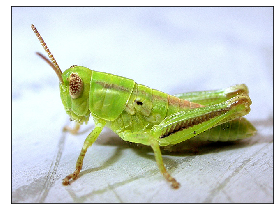

1

Image path: /mnt/md0/reynolds/ava-dataset/images/225034.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
2

Image path: /mnt/md0/reynolds/ava-dataset/images/177615.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
3

Image path: /mnt/md0/reynolds/ava-dataset/images/250203.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
4

Image path: /mnt/md0/reynolds/ava-dataset/images/169491.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
5

Image path: /mnt/md0/reynolds/ava-dataset/images/21026.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
6

Image path: /mnt/md0/reynolds/ava-dataset/images/262432.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
7

Image path: /mnt/md0/reynolds/ava-dataset/images/261155.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
8

Image path:


Image path: /mnt/md0/reynolds/ava-dataset/images/220836.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
61

Image path: /mnt/md0/reynolds/ava-dataset/images/129432.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
62

Image path: /mnt/md0/reynolds/ava-dataset/images/232658.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
63

Image path: /mnt/md0/reynolds/ava-dataset/images/235116.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
64

Image path: /mnt/md0/reynolds/ava-dataset/images/263472.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
65

Image path: /mnt/md0/reynolds/ava-dataset/images/2033.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
66

Image path: /mnt/md0/reynolds/ava-dataset/images/194076.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
67

Image p

118

Image path: /mnt/md0/reynolds/ava-dataset/images/204946.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
119

Image path: /mnt/md0/reynolds/ava-dataset/images/12454.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
120

Image path: /mnt/md0/reynolds/ava-dataset/images/250880.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
121

Image path: /mnt/md0/reynolds/ava-dataset/images/144409.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
122

Image path: /mnt/md0/reynolds/ava-dataset/images/141521.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
123

Image path: /mnt/md0/reynolds/ava-dataset/images/20511.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
124

Image path: /mnt/md0/reynolds/ava-dataset/images/154974.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
1


Image path: /mnt/md0/reynolds/ava-dataset/images/12198.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
177

Image path: /mnt/md0/reynolds/ava-dataset/images/19733.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
178

Image path: /mnt/md0/reynolds/ava-dataset/images/204234.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
179

Image path: /mnt/md0/reynolds/ava-dataset/images/153492.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
180

Image path: /mnt/md0/reynolds/ava-dataset/images/132848.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
181

Image path: /mnt/md0/reynolds/ava-dataset/images/22787.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
182

Image path: /mnt/md0/reynolds/ava-dataset/images/196253.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
183

I


Image path: /mnt/md0/reynolds/ava-dataset/images/263616.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
235

Image path: /mnt/md0/reynolds/ava-dataset/images/209053.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
236

Image path: /mnt/md0/reynolds/ava-dataset/images/165966.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
237

Image path: /mnt/md0/reynolds/ava-dataset/images/190048.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
238

Image path: /mnt/md0/reynolds/ava-dataset/images/258261.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
239

Image path: /mnt/md0/reynolds/ava-dataset/images/172588.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
240

Image path: /mnt/md0/reynolds/ava-dataset/images/173669.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
241

293

Image path: /mnt/md0/reynolds/ava-dataset/images/140889.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
294

Image path: /mnt/md0/reynolds/ava-dataset/images/183067.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
295

Image path: /mnt/md0/reynolds/ava-dataset/images/106096.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
296

Image path: /mnt/md0/reynolds/ava-dataset/images/10922.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
297

Image path: /mnt/md0/reynolds/ava-dataset/images/26663.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
298

Image path: /mnt/md0/reynolds/ava-dataset/images/108102.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
299

Image path: /mnt/md0/reynolds/ava-dataset/images/18259.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
30


Image path: /mnt/md0/reynolds/ava-dataset/images/188722.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
352

Image path: /mnt/md0/reynolds/ava-dataset/images/129441.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
353

Image path: /mnt/md0/reynolds/ava-dataset/images/17848.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
354

Image path: /mnt/md0/reynolds/ava-dataset/images/151424.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
355

Image path: /mnt/md0/reynolds/ava-dataset/images/179071.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
356

Image path: /mnt/md0/reynolds/ava-dataset/images/191278.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
357

Image path: /mnt/md0/reynolds/ava-dataset/images/232796.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
358



Image path: /mnt/md0/reynolds/ava-dataset/images/11448.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
410

Image path: /mnt/md0/reynolds/ava-dataset/images/270918.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
411

Image path: /mnt/md0/reynolds/ava-dataset/images/204792.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
412

Image path: /mnt/md0/reynolds/ava-dataset/images/212790.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
413

Image path: /mnt/md0/reynolds/ava-dataset/images/153678.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
414

Image path: /mnt/md0/reynolds/ava-dataset/images/249842.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
415

Image path: /mnt/md0/reynolds/ava-dataset/images/147602.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
416


468

Image path: /mnt/md0/reynolds/ava-dataset/images/255344.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
469

Image path: /mnt/md0/reynolds/ava-dataset/images/151373.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
470

Image path: /mnt/md0/reynolds/ava-dataset/images/115815.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
471

Image path: /mnt/md0/reynolds/ava-dataset/images/171224.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
472

Image path: /mnt/md0/reynolds/ava-dataset/images/18697.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
473

Image path: /mnt/md0/reynolds/ava-dataset/images/176731.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []
474

Image path: /mnt/md0/reynolds/ava-dataset/images/132629.jpg
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, file_path]
Index: []


In [19]:
limit_num_pictures = 500
vgg16.eval() # set to prediction mode
testing_loss = 0
testing_accuracy = 0
running_loss = 0.0
num_correct = 0

ratings_data = None
for i, data in enumerate(test_loader, 0):
    print(i)
    
    if limit_num_pictures:
        if i > limit_num_pictures:
            break
    inputs, _, path, label = data
#     path = path[0]
#     label = torch.LongTensor([int(label[0])])
    
    path = path[0]
    path_array = path.split('/')
    pic_name = path_array[-1]
#         print(pic_name)
#         print(pic_label_dict[pic_name.split('.')[0]])
#         label = torch.LongTensor(pic_label_dict[pic_name.split('.')[0]])
    label = pic_label_dict[pic_name.split('.')[0]]
    label = torch.LongTensor([label])

    output = vgg16(inputs)
    loss = criterion(output, label)

    running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    num_correct += (preds == label).sum().item()
    ratings = output[0].tolist()
    print("\nImage path: {}".format(path))
#     print("Classification for test image #{}: {}".format(i, ratings))
    tuple_to_insert = {}
    for n in range(10):
        tuple_to_insert[str(n + 1)] = [ratings[n]]
    tuple_to_insert['file_path'] = [path]
    tuple_to_insert = pandas.DataFrame.from_dict(tuple_to_insert)

    if i == 0:
        ratings_data = tuple_to_insert
    else:
        ratings_data = ratings_data.append(tuple_to_insert, ignore_index=True)
    print(ratings_data.tail(0))
    if i % 2000 == 0:
        fig = plt.figure(figsize=(16, 4))
        columns = 3
        rows = 1
        img = mpimg.imread(path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

testing_loss = running_loss/len(test_loader.dataset)
testing_accuracy = 100. * num_correct/len(test_loader.dataset)
ratings_data = ratings_data.set_index('file_path')

In [20]:
ratings_data

1           2  \
file_path                                                                  
/mnt/md0/reynolds/ava-dataset/images/199197.jpg   740.058289  -22.255810   
/mnt/md0/reynolds/ava-dataset/images/225034.jpg  -371.604492  689.238525   
/mnt/md0/reynolds/ava-dataset/images/177615.jpg  1326.652588  791.296631   
/mnt/md0/reynolds/ava-dataset/images/250203.jpg -2070.102051  115.614304   
/mnt/md0/reynolds/ava-dataset/images/169491.jpg  -964.531433  163.994675   
...                                                      ...         ...   
/mnt/md0/reynolds/ava-dataset/images/120270.jpg  -798.404602  167.917297   
/mnt/md0/reynolds/ava-dataset/images/106944.jpg   380.417114  491.744019   
/mnt/md0/reynolds/ava-dataset/images/177121.jpg  -404.980316 -112.750908   
/mnt/md0/reynolds/ava-dataset/images/150565.jpg   356.533264   -0.027431   
/mnt/md0/reynolds/ava-dataset/images/240533.jpg   742.768372  649.523743   

                                                           3            4  \
file_path                                                                   
/mnt/md0/reynolds/ava-dataset/images/199197.jpg -1993.871460 -5940.688477   
/mnt/md0/reynolds/ava-dataset/images/225034.jpg   827.298279 -1393.288696   
/mnt/md0/reynolds/ava-dataset/images/177615.jpg -1183.893799  2983.525879   
/mnt/md0/reynolds/ava-dataset/images/250203.jpg -3774.863037  3153.140381   
/mnt/md0/reynolds/ava-dataset/images/169491.jpg -1212.098999  -958.430237   
...                                                      ...          ...   
/mnt/md0/reynolds/ava-dataset/images/120270.jpg  -187.825211  2403.204834   
/mnt/md0/reynolds/ava-dataset/images/106944.jpg -3147.627930 -1475.606689   
/mnt/md0/reynolds/ava-dataset/images/177121.jpg -1115.697388  -617.272522   
/mnt/md0/reynolds/ava-dataset/images/150565.jpg -2450.125000   290.040344   
/mnt/md0/reynolds/ava-dataset/images/240533.jpg -1114.054932  5869.145508   

                                                           5             6  \
file_path                                                                    
/mnt/md0/reynolds/ava-dataset/images/199197.jpg  5081.551758  10596.126953   
/mnt/md0/reynolds/ava-dataset/images/225034.jpg  1657.214478   2091.997314   
/mnt/md0/reynolds/ava-dataset/images/177615.jpg  4591.952637  -3004.608398   
/mnt/md0/reynolds/ava-dataset/images/250203.jpg  9075.285156   1261.782349   
/mnt/md0/reynolds/ava-dataset/images/169491.jpg  1184.395142   6375.597656   
...                                                      ...           ...   
/mnt/md0/reynolds/ava-dataset/images/120270.jpg  -329.842407   1923.917236   
/mnt/md0/reynolds/ava-dataset/images/106944.jpg  5964.643066   5748.573242   
/mnt/md0/reynolds/ava-dataset/images/177121.jpg  -545.687622  11055.697266   
/mnt/md0/reynolds/ava-dataset/images/150565.jpg  3970.651611   6916.202637   
/mnt/md0/reynolds/ava-dataset/images/240533.jpg -6448.872559   6261.145020   

                                                           7            8  \
file_path                                                                   
/mnt/md0/reynolds/ava-dataset/images/199197.jpg -3920.541016 -4248.936035   
/mnt/md0/reynolds/ava-dataset/images/225034.jpg -1587.792603 -1668.482910   
/mnt/md0/reynolds/ava-dataset/images/177615.jpg -3646.060303 -1604.775757   
/mnt/md0/reynolds/ava-dataset/images/250203.jpg -6398.791504  -958.730835   
/mnt/md0/reynolds/ava-dataset/images/169491.jpg -3316.979980  -557.712524   
...                                                      ...          ...   
/mnt/md0/reynolds/ava-dataset/images/120270.jpg    85.350632 -2741.497559   
/mnt/md0/reynolds/ava-dataset/images/106944.jpg -7558.283203  -222.150650   
/mnt/md0/reynolds/ava-dataset/images/177121.jpg -5509.134766 -2739.494141   
/mnt/md0/reynolds/ava-dataset/images/150565.jpg -7363.666016 -1396.005249   
/mnt/md0/reynolds/ava-dataset/images/240533.jpg -5279.065918  -614.776794   

                                                   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4490073710>,
      dtype=object)

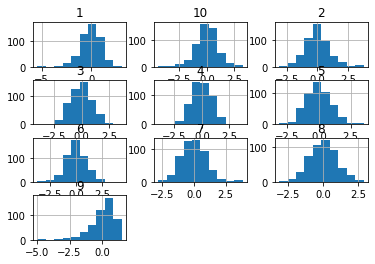

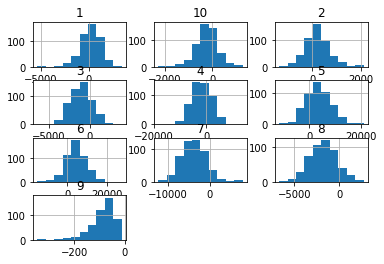

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
ratings_data_norm = pd.DataFrame(scaler.fit_transform(ratings_data), columns=ratings_data.columns, index=ratings_data.index)
ratings_data_norm.hist()
ratings_data.hist()

In [22]:
ratings_data_norm['classification'] = ratings_data_norm.idxmax(axis=1)
ratings_data_norm

1         2         3  \
file_path                                                                       
/mnt/md0/reynolds/ava-dataset/images/199197.jpg  0.491193 -0.459622 -0.722030   
/mnt/md0/reynolds/ava-dataset/images/225034.jpg -0.585485  0.956849  1.332480   
/mnt/md0/reynolds/ava-dataset/images/177615.jpg  1.059326  1.160030 -0.132166   
/mnt/md0/reynolds/ava-dataset/images/250203.jpg -2.230530 -0.185145 -2.019033   
/mnt/md0/reynolds/ava-dataset/images/169491.jpg -1.159753 -0.088827 -0.152706   
...                                                   ...       ...       ...   
/mnt/md0/reynolds/ava-dataset/images/120270.jpg -0.998854 -0.081018  0.593218   
/mnt/md0/reynolds/ava-dataset/images/106944.jpg  0.142870  0.563669 -1.562251   
/mnt/md0/reynolds/ava-dataset/images/177121.jpg -0.617811 -0.639783 -0.082502   
/mnt/md0/reynolds/ava-dataset/images/150565.jpg  0.119737 -0.415369 -1.054296   
/mnt/md0/reynolds/ava-dataset/images/240533.jpg  0.493817  0.877783 -0.081306   

                                                        4         5         6  \
file_path                                                                       
/mnt/md0/reynolds/ava-dataset/images/199197.jpg -1.016354  0.273528  1.203174   
/mnt/md0/reynolds/ava-dataset/images/225034.jpg  0.060534 -0.426914 -0.430315   
/mnt/md0/reynolds/ava-dataset/images/177615.jpg  1.097025  0.173381 -1.409281   
/mnt/md0/reynolds/ava-dataset/images/250203.jpg  1.137192  1.090438 -0.589785   
/mnt/md0/reynolds/ava-dataset/images/169491.jpg  0.163515 -0.523628  0.392486   
...                                                   ...       ...       ...   
/mnt/md0/reynolds/ava-dataset/images/120270.jpg  0.959597 -0.833362 -0.462601   
/mnt/md0/reynolds/ava-dataset/images/106944.jpg  0.041040  0.454162  0.272046   
/mnt/md0/reynolds/ava-dataset/images/177121.jpg  0.244306 -0.877513  1.291449   
/mnt/md0/reynolds/ava-dataset/images/150565.jpg  0.459170  0.046295  0.496327   
/mnt/md0/reynolds/ava-dataset/images/240533.jpg  1.780380 -2.084998  0.370502   

                                                        7         8         9  \
file_path                                                                       
/mnt/md0/reynolds/ava-dataset/images/199197.jpg -0.054626 -1.585624 -0.346830   
/mnt/md0/reynolds/ava-dataset/images/225034.jpg  0.720962  0.078855  0.207489   
/mnt/md0/reynolds/ava-dataset/images/177615.jpg  0.036633  0.119948 -0.104279   
/mnt/md0/reynolds/ava-dataset/images/250203.jpg -0.878590  0.536669 -1.533895   
/mnt/md0/reynolds/ava-dataset/images/169491.jpg  0.146045  0.795339 -0.393834   
...                                                   ...       ...       ...   
/mnt/md0/reynolds/ava-dataset/images/120270.jpg  1.277246 -0.613275 -1.002173   
/mnt/md0/reynolds/ava-dataset/images/106944.jpg -1.264096  1.011788 -0.353011   
/mnt/md0/reynolds/ava-dataset/images/177121.jpg -0.582799 -0.611983  0.674502   
/mnt/md0/reynolds/ava-dataset/images/150565.jpg -1.199390  0.254612  0.215931   
/mnt/md0/reynolds/ava-dataset/images/240533.jpg -0.506306  0.758531 -0.037649   

                                                       10 classification  
file_path                                                                 
/mnt/md0/reynolds/ava-dataset/images/199197.jpg  0.095463              6  
/mnt/md0/reynolds/ava-dataset/images/225034.jpg  0.139475              3  
/mnt/md0/reynolds/ava-dataset/images/177615.jpg  0.150086              2  
/mnt/md0/reynolds/ava-dataset/images/250203.jpg -0.006566              4  
/mnt/md0/reynolds/ava-dataset/images/169491.jpg -0.801476              8  
...                                                   ...            ...  
/mnt/md0/reynolds/ava-dataset/images/120270.jpg -0.321829              7  
/mnt/md0/reynolds/ava-dataset/images/106944.jpg  0.332821              8  
/mnt/md0/reynolds/ava-dataset/images/177121.jpg  0.583957              6  
/mnt/md0/reynolds/ava-dataset/images/150565.jpg -0.033229            

In [23]:
ratings_data_norm = ratings_data_norm.sort_values(by=['classification'])
ratings_data_norm

1         2         3  \
file_path                                                                       
/mnt/md0/reynolds/ava-dataset/images/12899.jpg   1.355757 -0.566826 -0.200350   
/mnt/md0/reynolds/ava-dataset/images/149803.jpg  1.625525  0.294946 -1.450641   
/mnt/md0/reynolds/ava-dataset/images/253663.jpg  1.651541 -0.226047  0.749384   
/mnt/md0/reynolds/ava-dataset/images/179078.jpg  1.415470 -0.055296  0.107559   
/mnt/md0/reynolds/ava-dataset/images/116716.jpg  2.588472  0.037054  0.821149   
...                                                   ...       ...       ...   
/mnt/md0/reynolds/ava-dataset/images/220028.jpg -0.633843  0.007703  0.099083   
/mnt/md0/reynolds/ava-dataset/images/12918.jpg   0.290619 -0.374326 -0.252645   
/mnt/md0/reynolds/ava-dataset/images/135123.jpg  0.645735 -1.699136  0.640815   
/mnt/md0/reynolds/ava-dataset/images/12253.jpg   0.740629 -0.107476 -0.849527   
/mnt/md0/reynolds/ava-dataset/images/12289.jpg  -0.764850 -0.091955  0.561685   

                                                        4         5         6  \
file_path                                                                       
/mnt/md0/reynolds/ava-dataset/images/12899.jpg  -0.710213  0.111220  0.930063   
/mnt/md0/reynolds/ava-dataset/images/149803.jpg -0.634453 -0.828497  1.375731   
/mnt/md0/reynolds/ava-dataset/images/253663.jpg -1.381137 -0.494013  1.186882   
/mnt/md0/reynolds/ava-dataset/images/179078.jpg -0.101239  0.196449 -0.161239   
/mnt/md0/reynolds/ava-dataset/images/116716.jpg -0.520788  0.240583 -0.559832   
...                                                   ...       ...       ...   
/mnt/md0/reynolds/ava-dataset/images/220028.jpg -0.307207  0.438218 -0.237758   
/mnt/md0/reynolds/ava-dataset/images/12918.jpg   0.401456  0.461347 -0.472462   
/mnt/md0/reynolds/ava-dataset/images/135123.jpg  0.955560 -0.516191 -0.490215   
/mnt/md0/reynolds/ava-dataset/images/12253.jpg  -0.214343  0.097451 -0.199095   
/mnt/md0/reynolds/ava-dataset/images/12289.jpg   0.144113  0.623894 -0.793944   

                                                        7         8         9  \
file_path                                                                       
/mnt/md0/reynolds/ava-dataset/images/12899.jpg  -1.023329 -0.437447 -0.674135   
/mnt/md0/reynolds/ava-dataset/images/149803.jpg -0.225363  0.111770  0.196175   
/mnt/md0/reynolds/ava-dataset/images/253663.jpg  0.069401 -0.927976  0.968528   
/mnt/md0/reynolds/ava-dataset/images/179078.jpg  0.080749 -1.054706 -0.175424   
/mnt/md0/reynolds/ava-dataset/images/116716.jpg -0.078545  0.192970  0.281755   
...                                                   ...       ...       ...   
/mnt/md0/reynolds/ava-dataset/images/220028.jpg -0.011730  0.626122  1.240159   
/mnt/md0/reynolds/ava-dataset/images/12918.jpg  -0.511700  0.043131  1.044037   
/mnt/md0/reynolds/ava-dataset/images/135123.jpg  0.215409 -0.557314  1.206116   
/mnt/md0/reynolds/ava-dataset/images/12253.jpg   0.230809  0.998607  1.255951   
/mnt/md0/reynolds/ava-dataset/images/12289.jpg   0.235282  0.086003  0.904417   

                                                       10 classification  
file_path                                                                 
/mnt/md0/reynolds/ava-dataset/images/12899.jpg   1.209039              1  
/mnt/md0/reynolds/ava-dataset/images/149803.jpg  0.482529              1  
/mnt/md0/reynolds/ava-dataset/images/253663.jpg  1.342382              1  
/mnt/md0/reynolds/ava-dataset/images/179078.jpg  0.268927              1  
/mnt/md0/reynolds/ava-dataset/images/116716.jpg  0.091725              1  
...                                                   ...            ...  
/mnt/md0/reynolds/ava-dataset/images/220028.jpg -0.198605              9  
/mnt/md0/reynolds/ava-dataset/images/12918.jpg   0.345503              9  
/mnt/md0/reynolds/ava-dataset/images/135123.jpg  1.071861              9  
/mnt/md0/reynolds/ava-dataset/images/12253.jpg  -0.828344            

In [24]:
bad_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '8']
good_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '1']

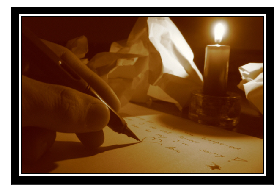

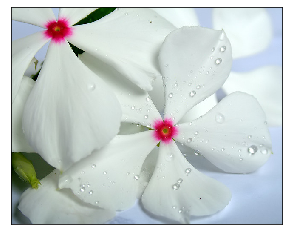

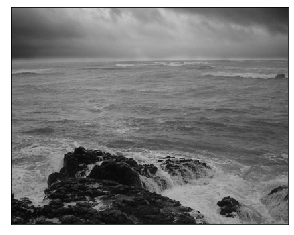

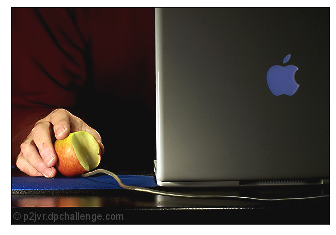

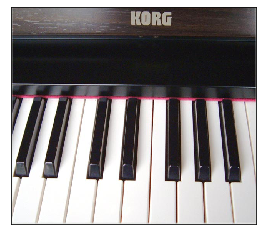

In [25]:
fig = plt.figure(figsize=(16, 4))
for path in good_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

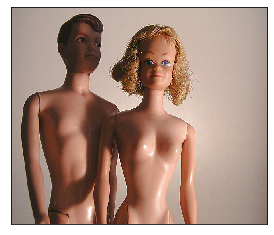

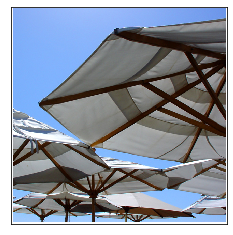

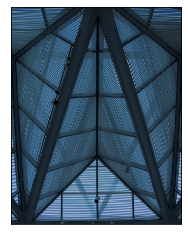

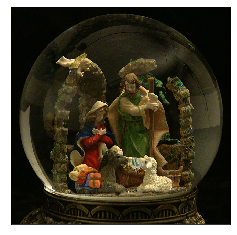

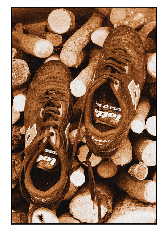

In [26]:
# fig = plt.figure(figsize=(16, 4))
for path in bad_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()